In [1]:
from tomographic_lensing import *
from CovMat import *
import gc

In [2]:
# Input Cosmology object with a given set of parameters
cosmo = ccl.Cosmology(
    Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96,
    transfer_function='bbks')

ell = np.arange(2, 10001)

In [3]:
dndz1=GalaxyDistr(zi=0.001, zf=4.0, n_eff=10.024, z0=0.13, alpha=0.78)
#n_eff is chosen from the last column of Table F1,"https://arxiv.org/abs/1809.01669" LSST Science Requirements Document
#z0 and alpha are from Figure F4, Y1 of the same document

In [4]:
arcmin_per_str=(180*60/np.pi)**2
#how many square arcminutes are there in a steradian 
num_den_per_str = arcmin_per_str*10.024/0.28**2

In [5]:
# create bins of dndz using A.equal redshift bins, and B.equal galaxy number bins
def sliced_equal_z(dndz, nbins_z):
    n = nbins_z
    min_z = dndz[ :, 0].min()
    inc = (dndz[ :, 0].max()-min_z)/n
    #this calculates the increment in refshifts for each bin
    dndz_cut = {}
    #create an empty dictionary for sliced galaxy number density distribution
    for i in range(n):
        dndz_cut["bin_{}".format(i)] = dndz[np.logical_and(dndz[:,0]>inc*i+min_z, dndz[:,0]<inc*(i+1)+min_z)]
    return dndz_cut

def sliced_equal_n(dndz, nbins_z):
    n = nbins_z
    cdf = np.array([np.sum(dndz1[:i+1,1]) for i in range(len(dndz1[:,1]))])
    #find the cumulative density function
    inc = cdf[-1]/n
    #cdf[-1] gives the total number of galaxies in the sky. each bin has total/n galaxies
    dndz_cut = {}
    #create an empty dictionary for sliced galaxy number density distribution
    for i in range(n):
        dndz_cut["bin_{}".format(i)] = dndz[np.logical_and(cdf>inc*i, cdf<inc*(i+1))]
    return dndz_cut

In [6]:
def getCl(dndz_sliced, ell, cosmo):
    """This function calculats auto- and cross-power spectra for given sliced galaxy-redshift distribution."""
    n = len(dndz_sliced);
    lens = [[]]*n
    for i, dndz in enumerate(dndz_sliced.values()):
        lens[i] = ccl.WeakLensingTracer(cosmo, dndz=(dndz[:,0], dndz[:,1]))
    #create an empty n-by-n array that stores the lensing cross power spectrum between the ith and jth bin
    cl=[]
    for j in range(n):
        cl.extend(ccl.angular_cl(cosmo, lens[j], lens[j+i], ell) for i in range(n-j))
    cl_arr = np.array(cl)
    return cl_arr

In [7]:
def getCovMat(fsky, n_bins, cl, ell, numdenPerStr):
    l = []
    for j in range(n_bins):
        l.extend([[j, j+i] for i in range(n_bins-j)])
    cl_bin = np.vstack((ell, cl)).T
    numden = [numdenPerStr]*n_bins
    cov_arr = np.array(multi_bin_cov(fsky, cl_bin, np.array(l), numden))
    return cov_arr

In [8]:
cl = {} 
cov = {}
sliced_dndz = {}

for rbins in [5]:
    for rbin_type in ["z", "n"]:
        if rbin_type == "z":
            sliced_dndz["{0}_{1}".format(rbin_type, rbins)] = sliced_equal_z(dndz1, rbins)
        else:
            sliced_dndz["{0}_{1}".format(rbin_type, rbins)] = sliced_equal_n(dndz1, rbins)
        cl["{0}_{1}".format(rbin_type, rbins)] = getCl(sliced_dndz["{0}_{1}".format(rbin_type, rbins)], ell, cosmo)
        cov["{0}_{1}".format(rbin_type, rbins)] = getCovMat(fsky=0.4, n_bins=rbins, cl=cl["{0}_{1}".format(rbin_type, rbins)], ell=ell, numdenPerStr=num_den_per_str)


In [9]:
def SignalToNoise_o(cl, cov):
    """calculate the signal to noise for the given cl signal, and covariance array, without binning in l"""
    stn_sq = 0
    for i in range(cl.shape[1]):
        stn_sq = stn_sq + np.matmul(cl[:, i].T, 
                                    np.matmul(np.linalg.inv(cov[i,:,:]), cl[:, i]))
    stn = np.sqrt(stn_sq)
    return stn

In [10]:
stn = {}
for i in ["z", "n"]:
    for j in [5]:
        stn["{0}_{1}".format(i,j)] = SignalToNoise_o(cl = cl["{0}_{1}".format(i, j)], cov = cov["{0}_{1}".format(i, j)])

In [11]:
stn

{'z_5': 1769.747979407873, 'n_5': 818.4592484509981}

In [12]:
#check 5 tomographic bins: how much does each bin contribute to the total signal to noise
l = []
for j in range(5):
    l.extend([[j, j+i] for i in range(5-j)])

In [13]:
l

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 2],
 [2, 3],
 [2, 4],
 [3, 3],
 [3, 4],
 [4, 4]]

In [14]:
cl["z_5"].shape

(15, 9999)

In [15]:
cov["z_5"][:, 0, 0].shape

(9999,)

In [16]:
def SignalToNoise_bin(cl, cov):
    """calculate the signal to noise for the given cl signal, and covariance array, without binning in z"""
    stn_sq = 0
    for i in range(len(cl)):
        stn_sq = stn_sq + cl[i]**2/cov[i]
    stn = np.sqrt(stn_sq)
    return stn

In [17]:
SignalToNoise_bin(cl["z_5"][0], cov["z_5"][:, 0, 0])

124.68944896705639

In [18]:
for i in ["z", "n"]:
    for j in [0, 5, 9, 12, 14]:
        stn["{0}_5_bin_{1}".format(i,j+1)] = SignalToNoise_bin(cl = cl["{0}_5".format(i)][j], cov = cov["{0}_5".format(i)][:, j, j])

In [19]:
stn["z_5_bin_1"]

124.68944896705639

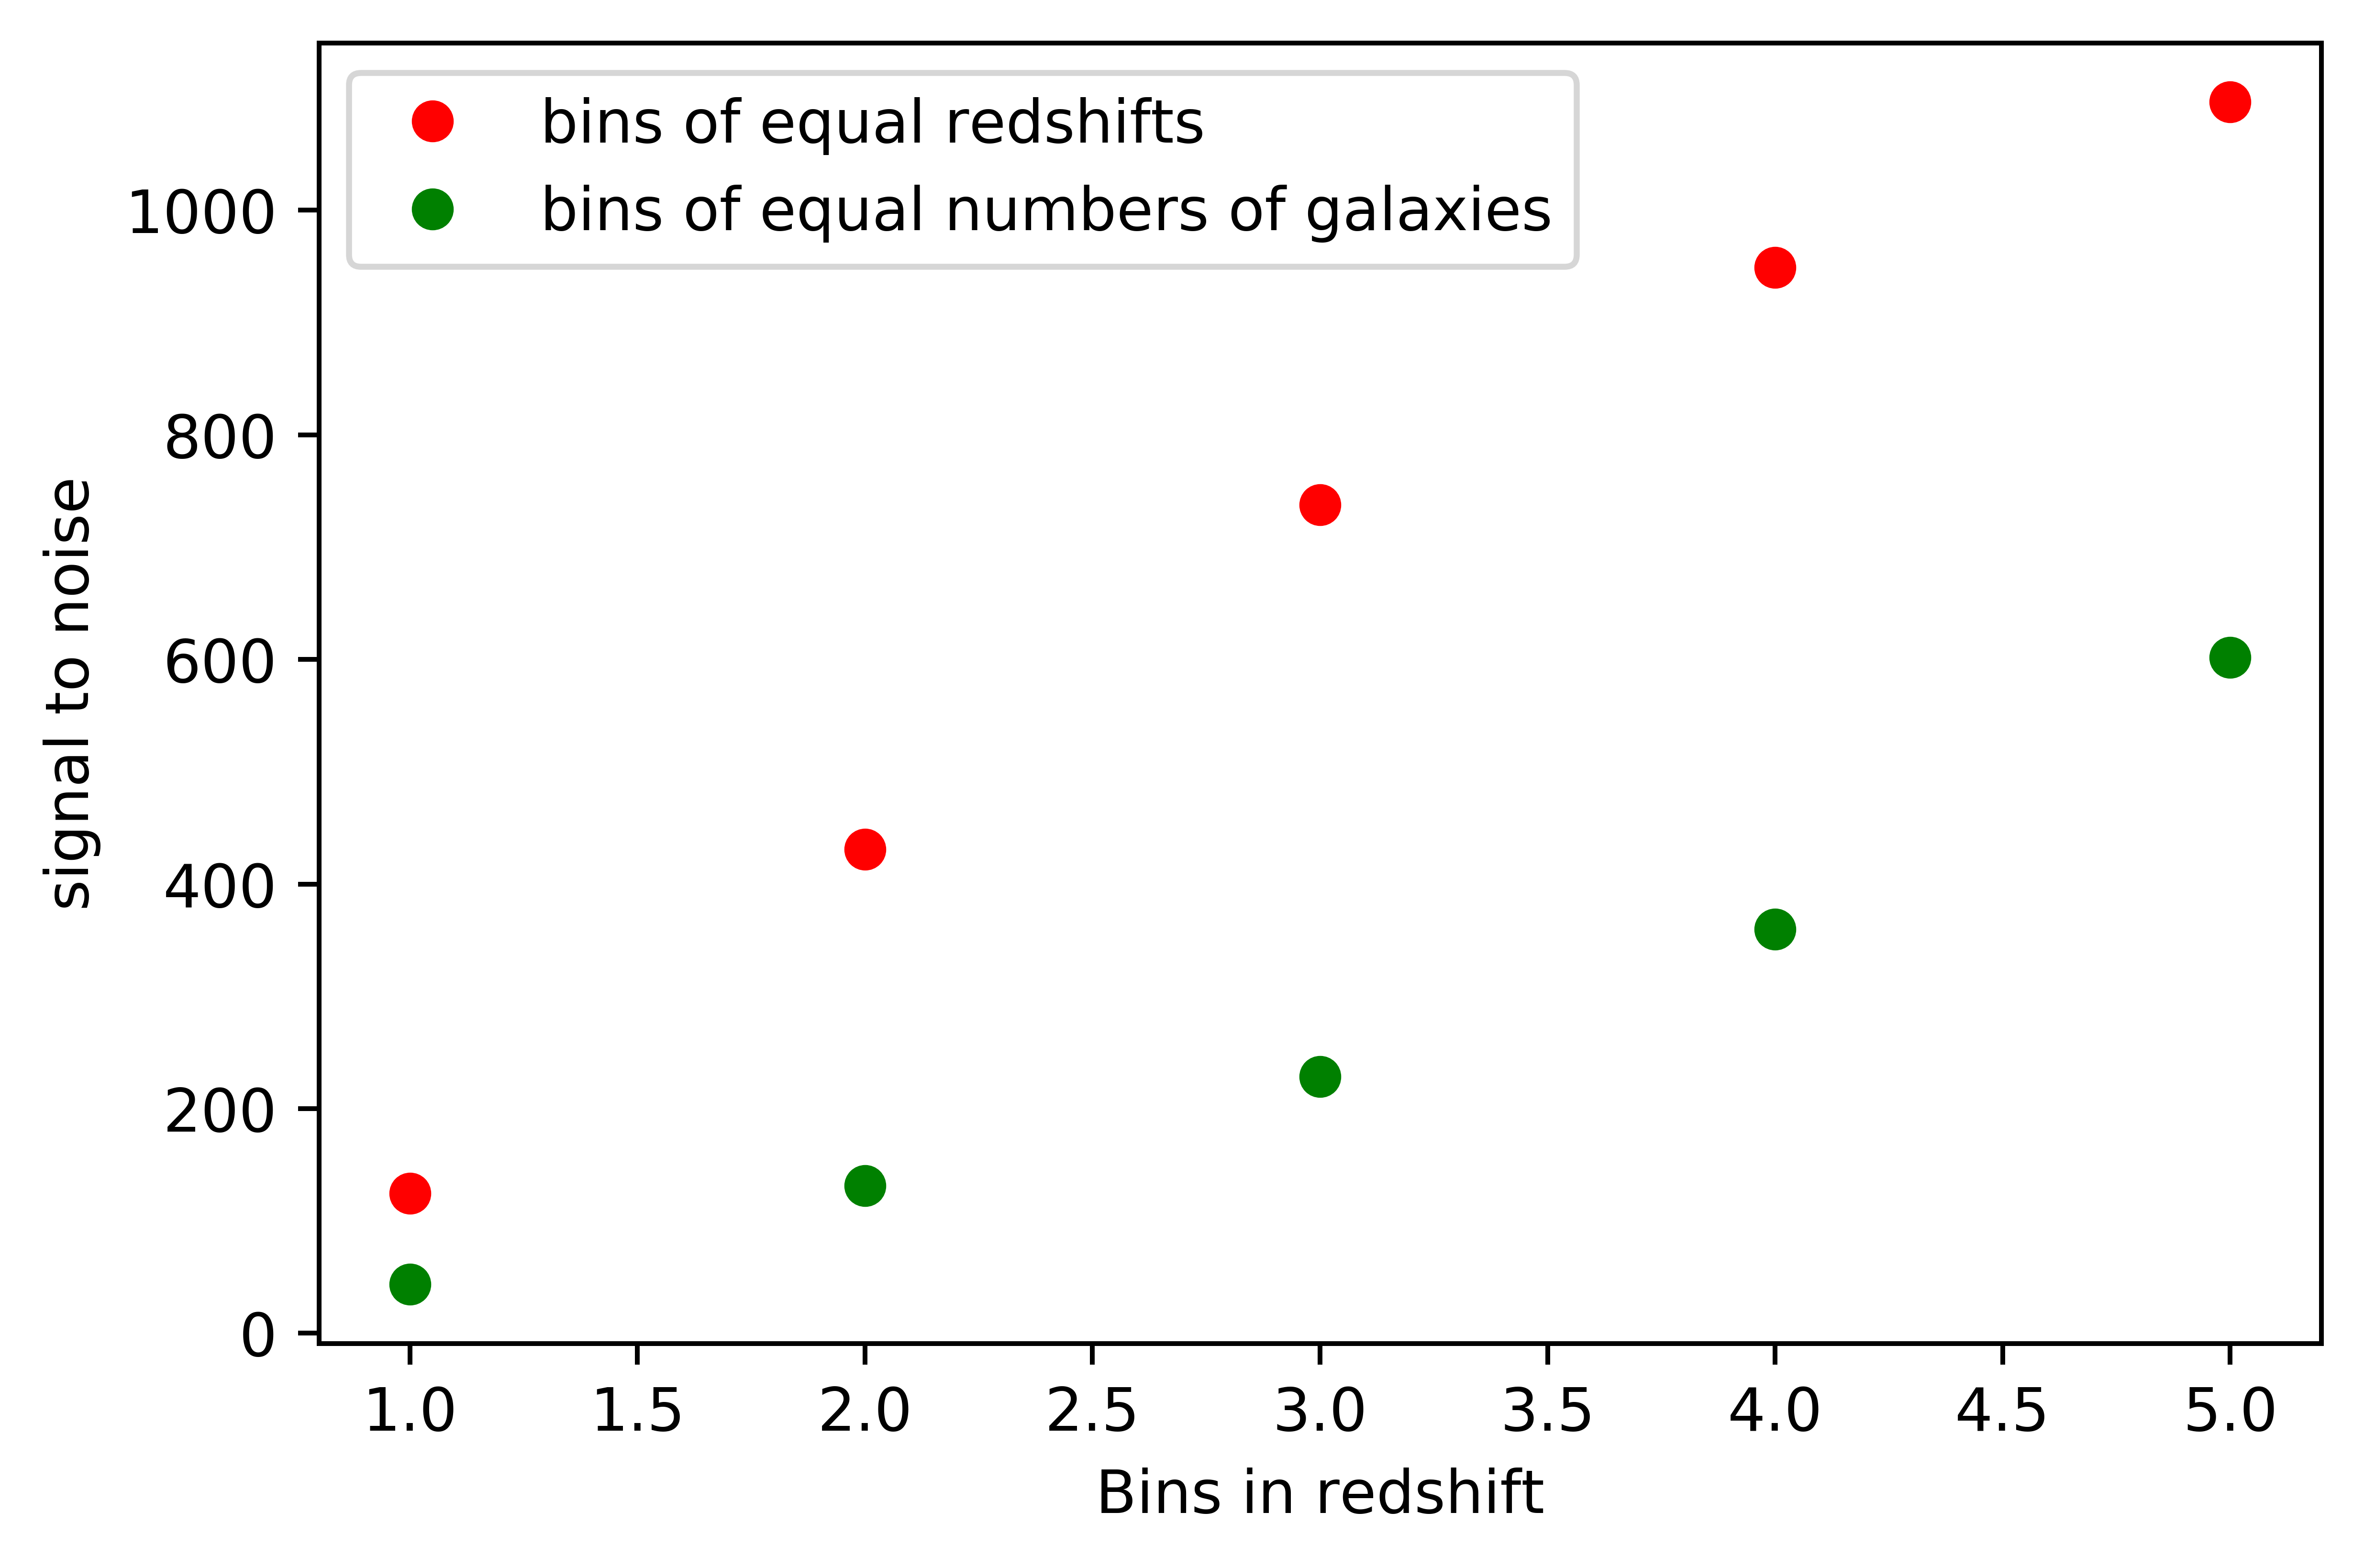

In [20]:
params = {'legend.fontsize': 10,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4, 5], [stn["z_5_bin_1"], stn["z_5_bin_6"], stn["z_5_bin_10"], stn["z_5_bin_13"], stn["z_5_bin_15"]],
         color='r', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal redshifts")
plt.plot([1, 2, 3, 4, 5], [stn["n_5_bin_1"], stn["n_5_bin_6"], stn["n_5_bin_10"], stn["n_5_bin_13"], stn["n_5_bin_15"]],
         color='g', linestyle='None', marker ="o", markersize = 6.0, label = "bins of equal numbers of galaxies")
plt.xlabel("Bins in redshift")
plt.ylabel("signal to noise")
plt.legend(loc="upper left")
plt.show() 

In [21]:
sliced_dndz["n_5"]['bin_4'][-1][0]

3.9899774436090225

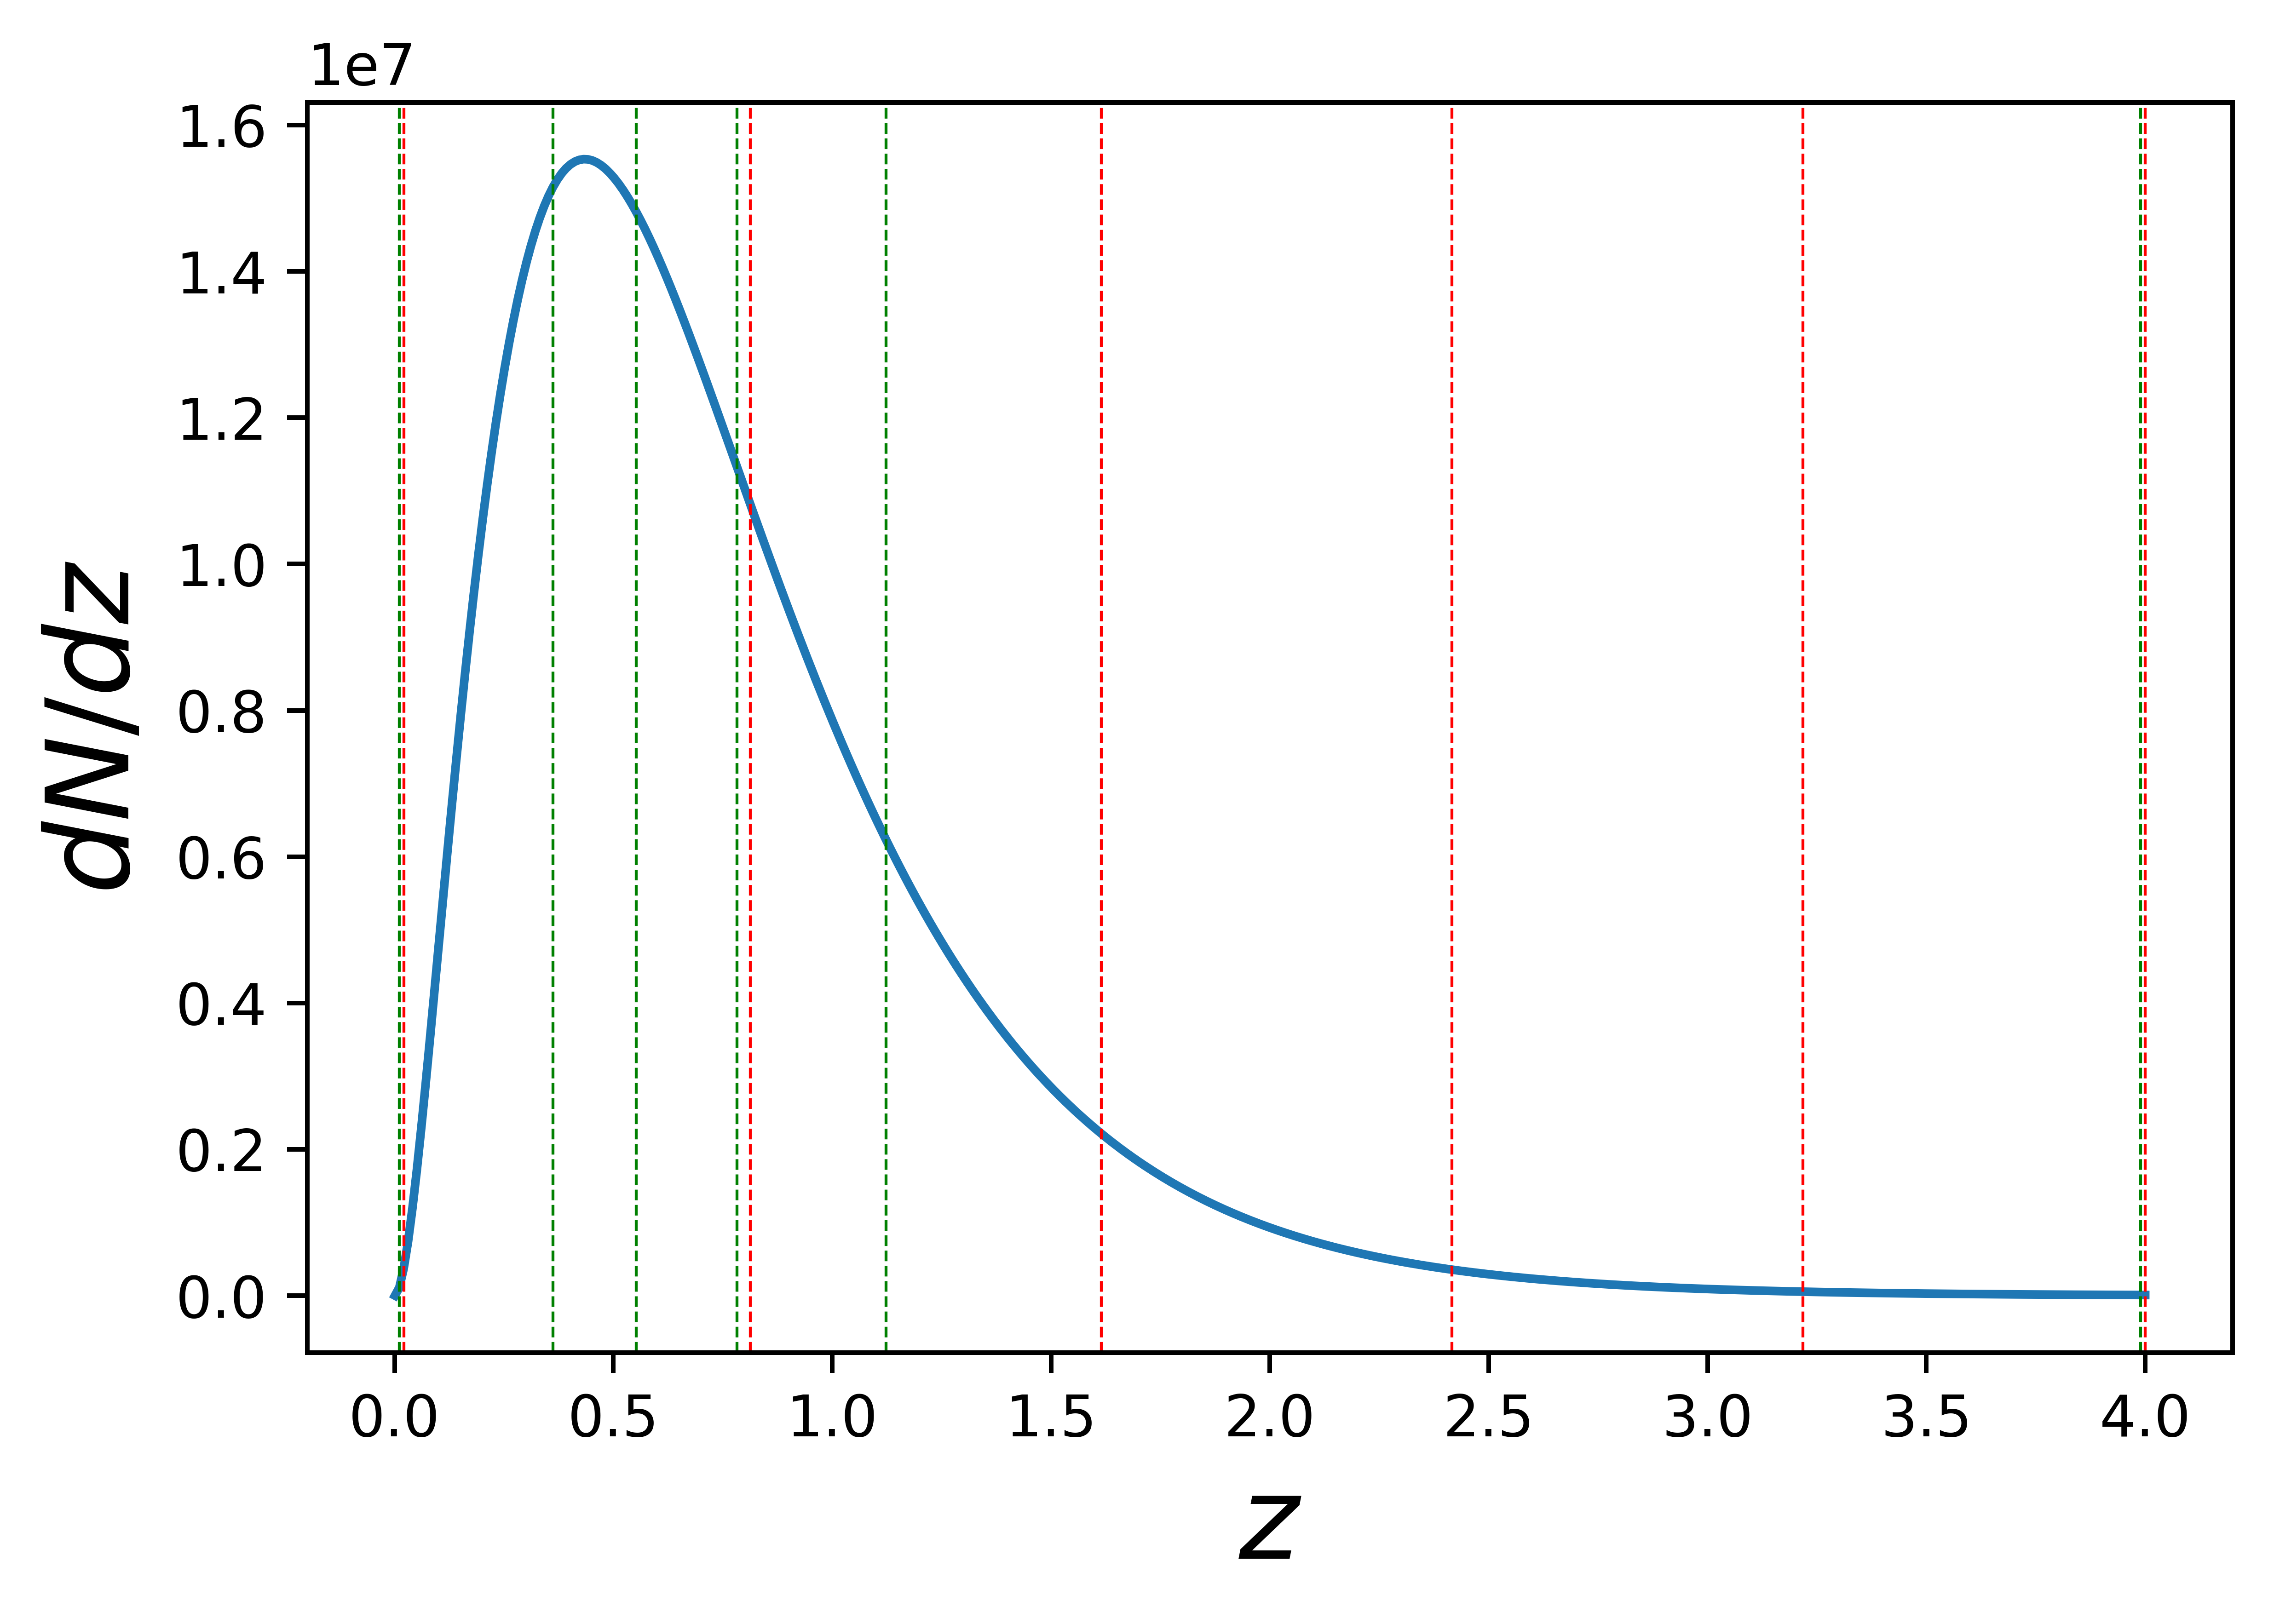

In [22]:
plt.plot(dndz1[:,0], dndz1[:,1])
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$dN/dz$',fontsize=20)
for x in sliced_dndz["n_5"].values():
    plt.axvline(x[1][0], linewidth=0.5, color="g", linestyle="--")
for x in sliced_dndz["z_5"].values():
    plt.axvline(x[1][0], linewidth=0.5, color="r", linestyle="--")
plt.axvline(sliced_dndz["z_5"]['bin_4'][-1][0], linewidth=0.5, color="r", linestyle="--")
plt.axvline(sliced_dndz["n_5"]['bin_4'][-1][0], linewidth=0.5, color="g", linestyle="--")
plt.show()

In [23]:
for x in sliced_dndz["n_5"].values():
    print(x[1][0])

0.011022556390977444
0.361812030075188
0.5522406015037594
0.7827593984962405
1.1235263157894735


In [24]:
#bin number starts to count from 0, so bin 3 is bin_2
np.sum(sliced_dndz["n_5"]["bin_2"][:,1])

308199625.3101774

In [25]:
for x in sliced_dndz["z_5"].values():
    print(x[1][0])
    
np.sum(sliced_dndz["z_5"]["bin_2"][:,1])

0.021045112781954887
0.8128270676691729
1.6146315789473682
2.416436090225564
3.218240601503759


84798848.18916968

#bin 3 for equal galaxy number has redshift range of 0.5522-0.7827, with 308199625 galaxies

#bin 3 for equal redshift has redshift range of 1.6146-2.4164, with 84798848 galaxies

In [26]:
308199625.3101774/84798848.18916968

3.634478909697502

In [27]:
cl["n_5"][9].shape

(9999,)

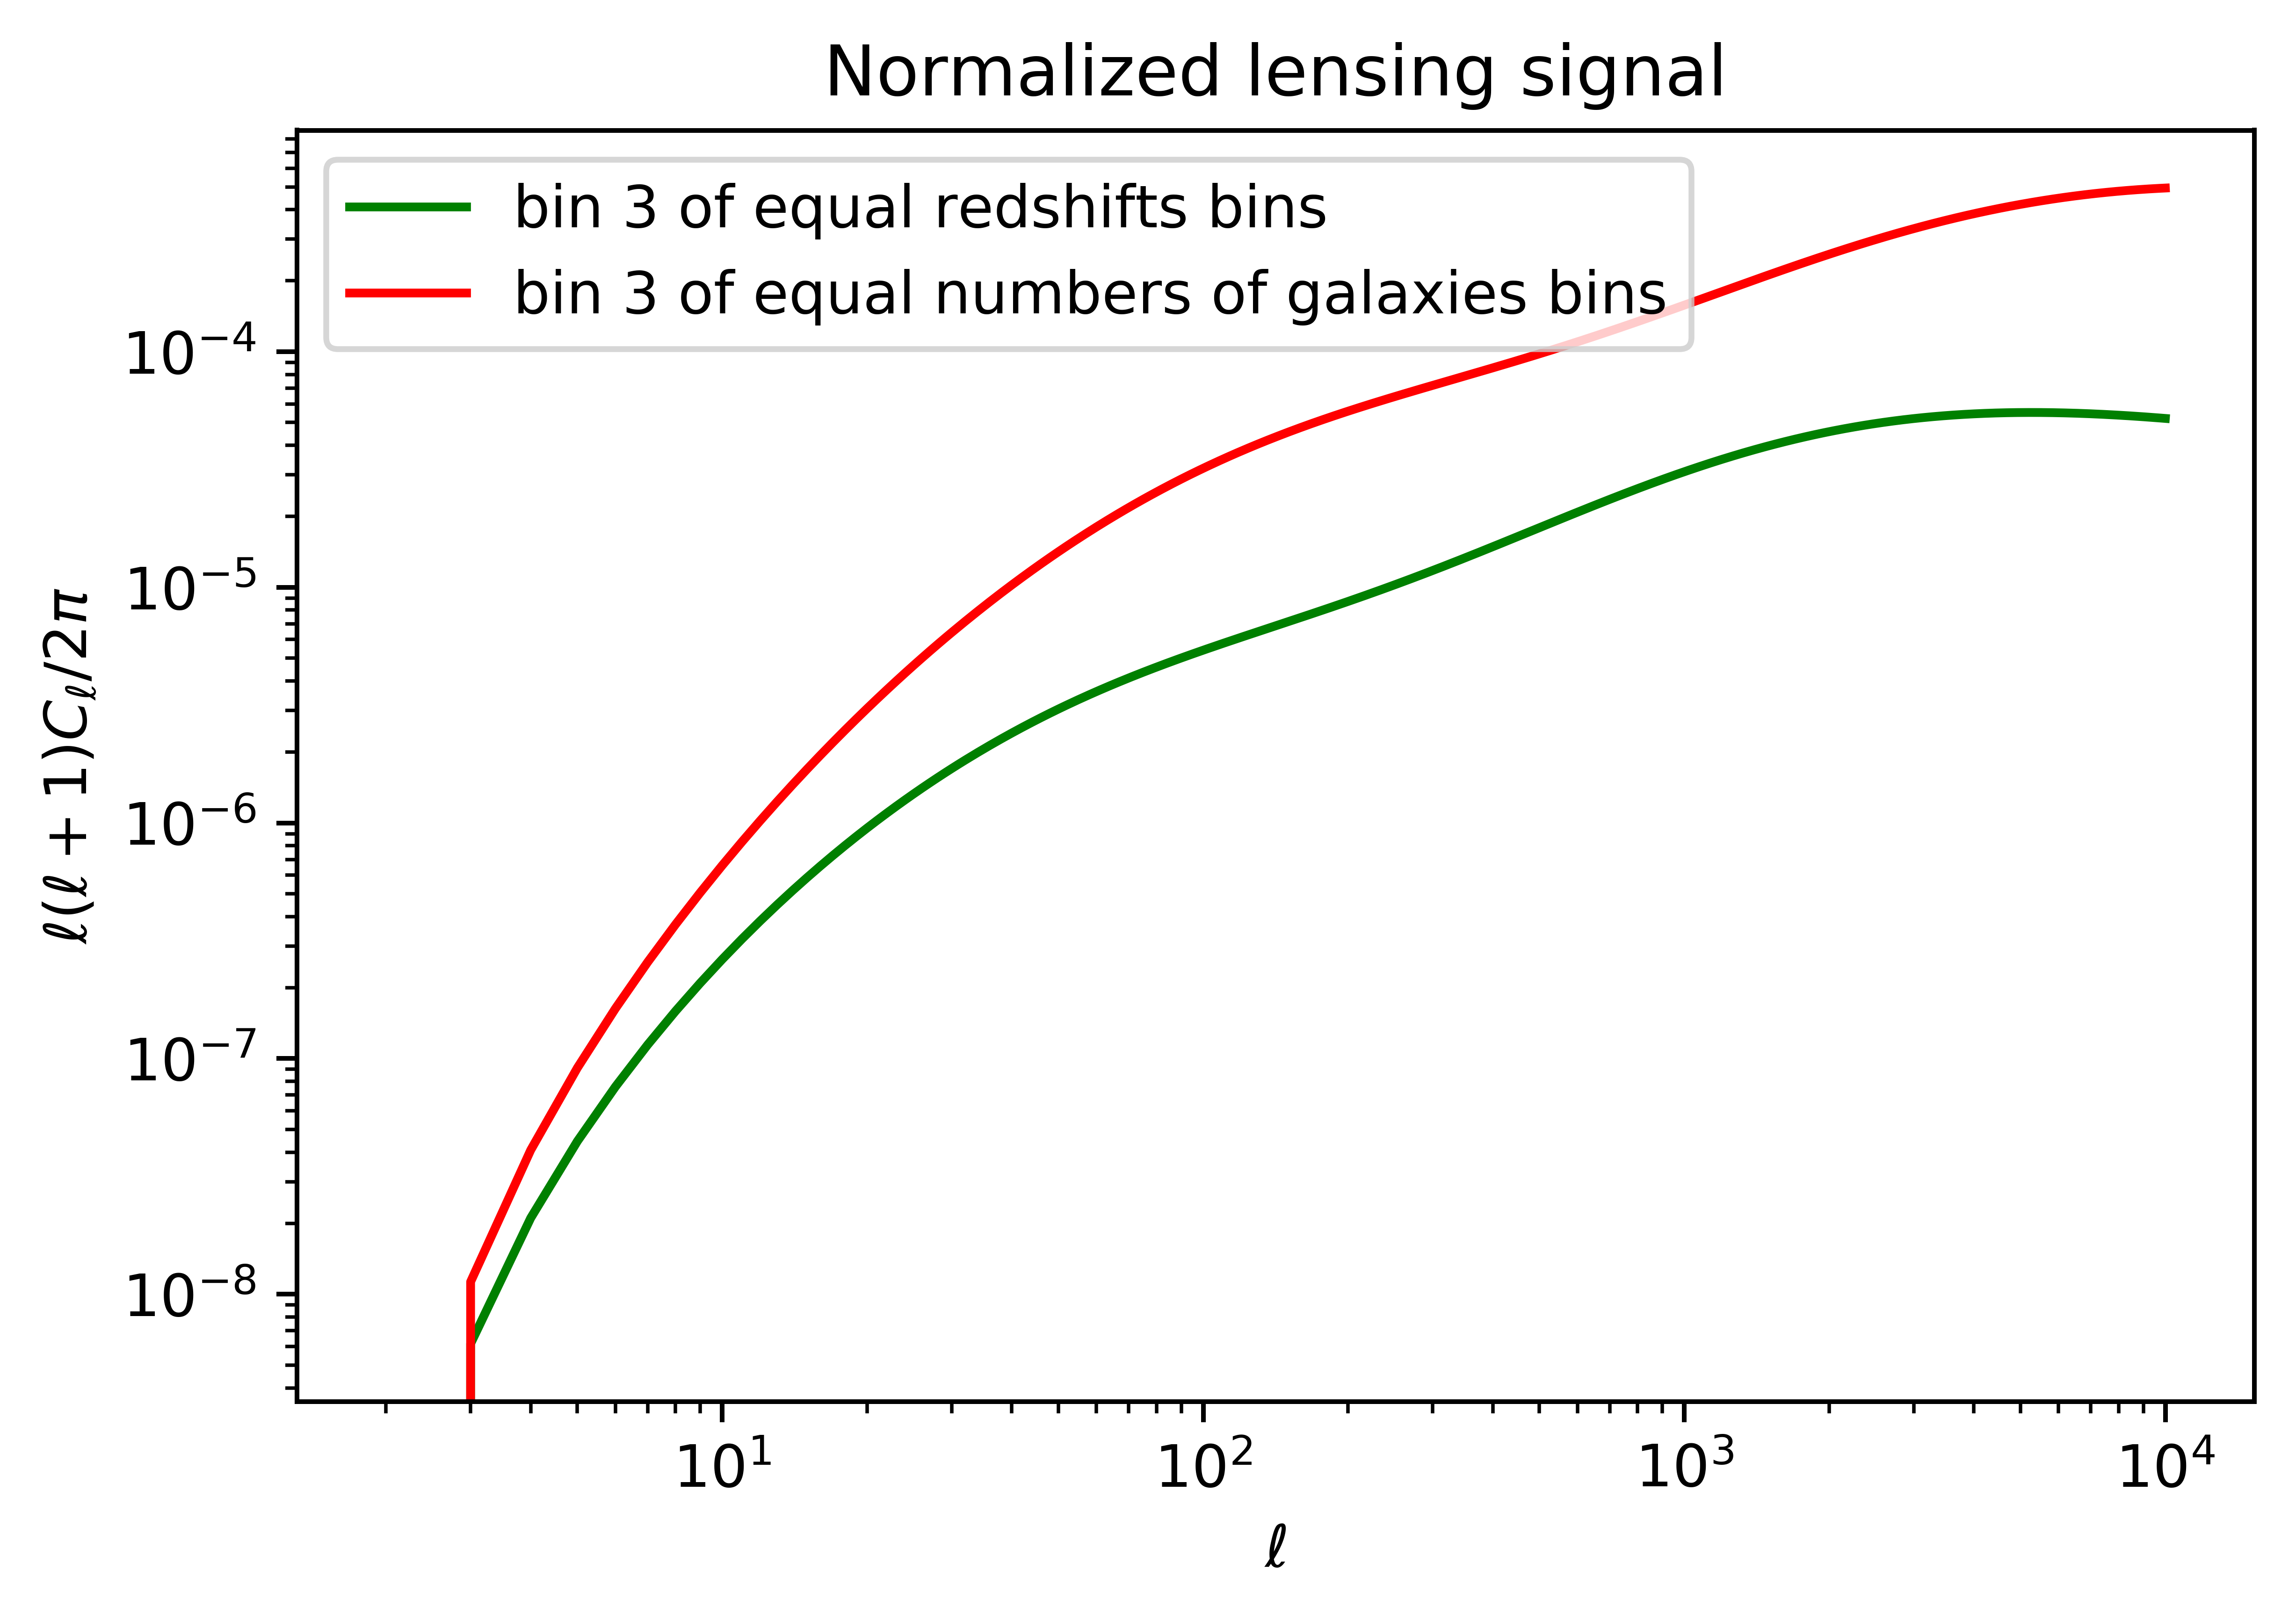

In [28]:
plt.figure()
plt.loglog(ell, normalizing(cl["n_5"][9]), color='g', label = "bin 3 of equal redshifts bins")
plt.loglog(ell, normalizing(cl["z_5"][9]), color='r', label = "bin 3 of equal numbers of galaxies bins")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal")
plt.show() 

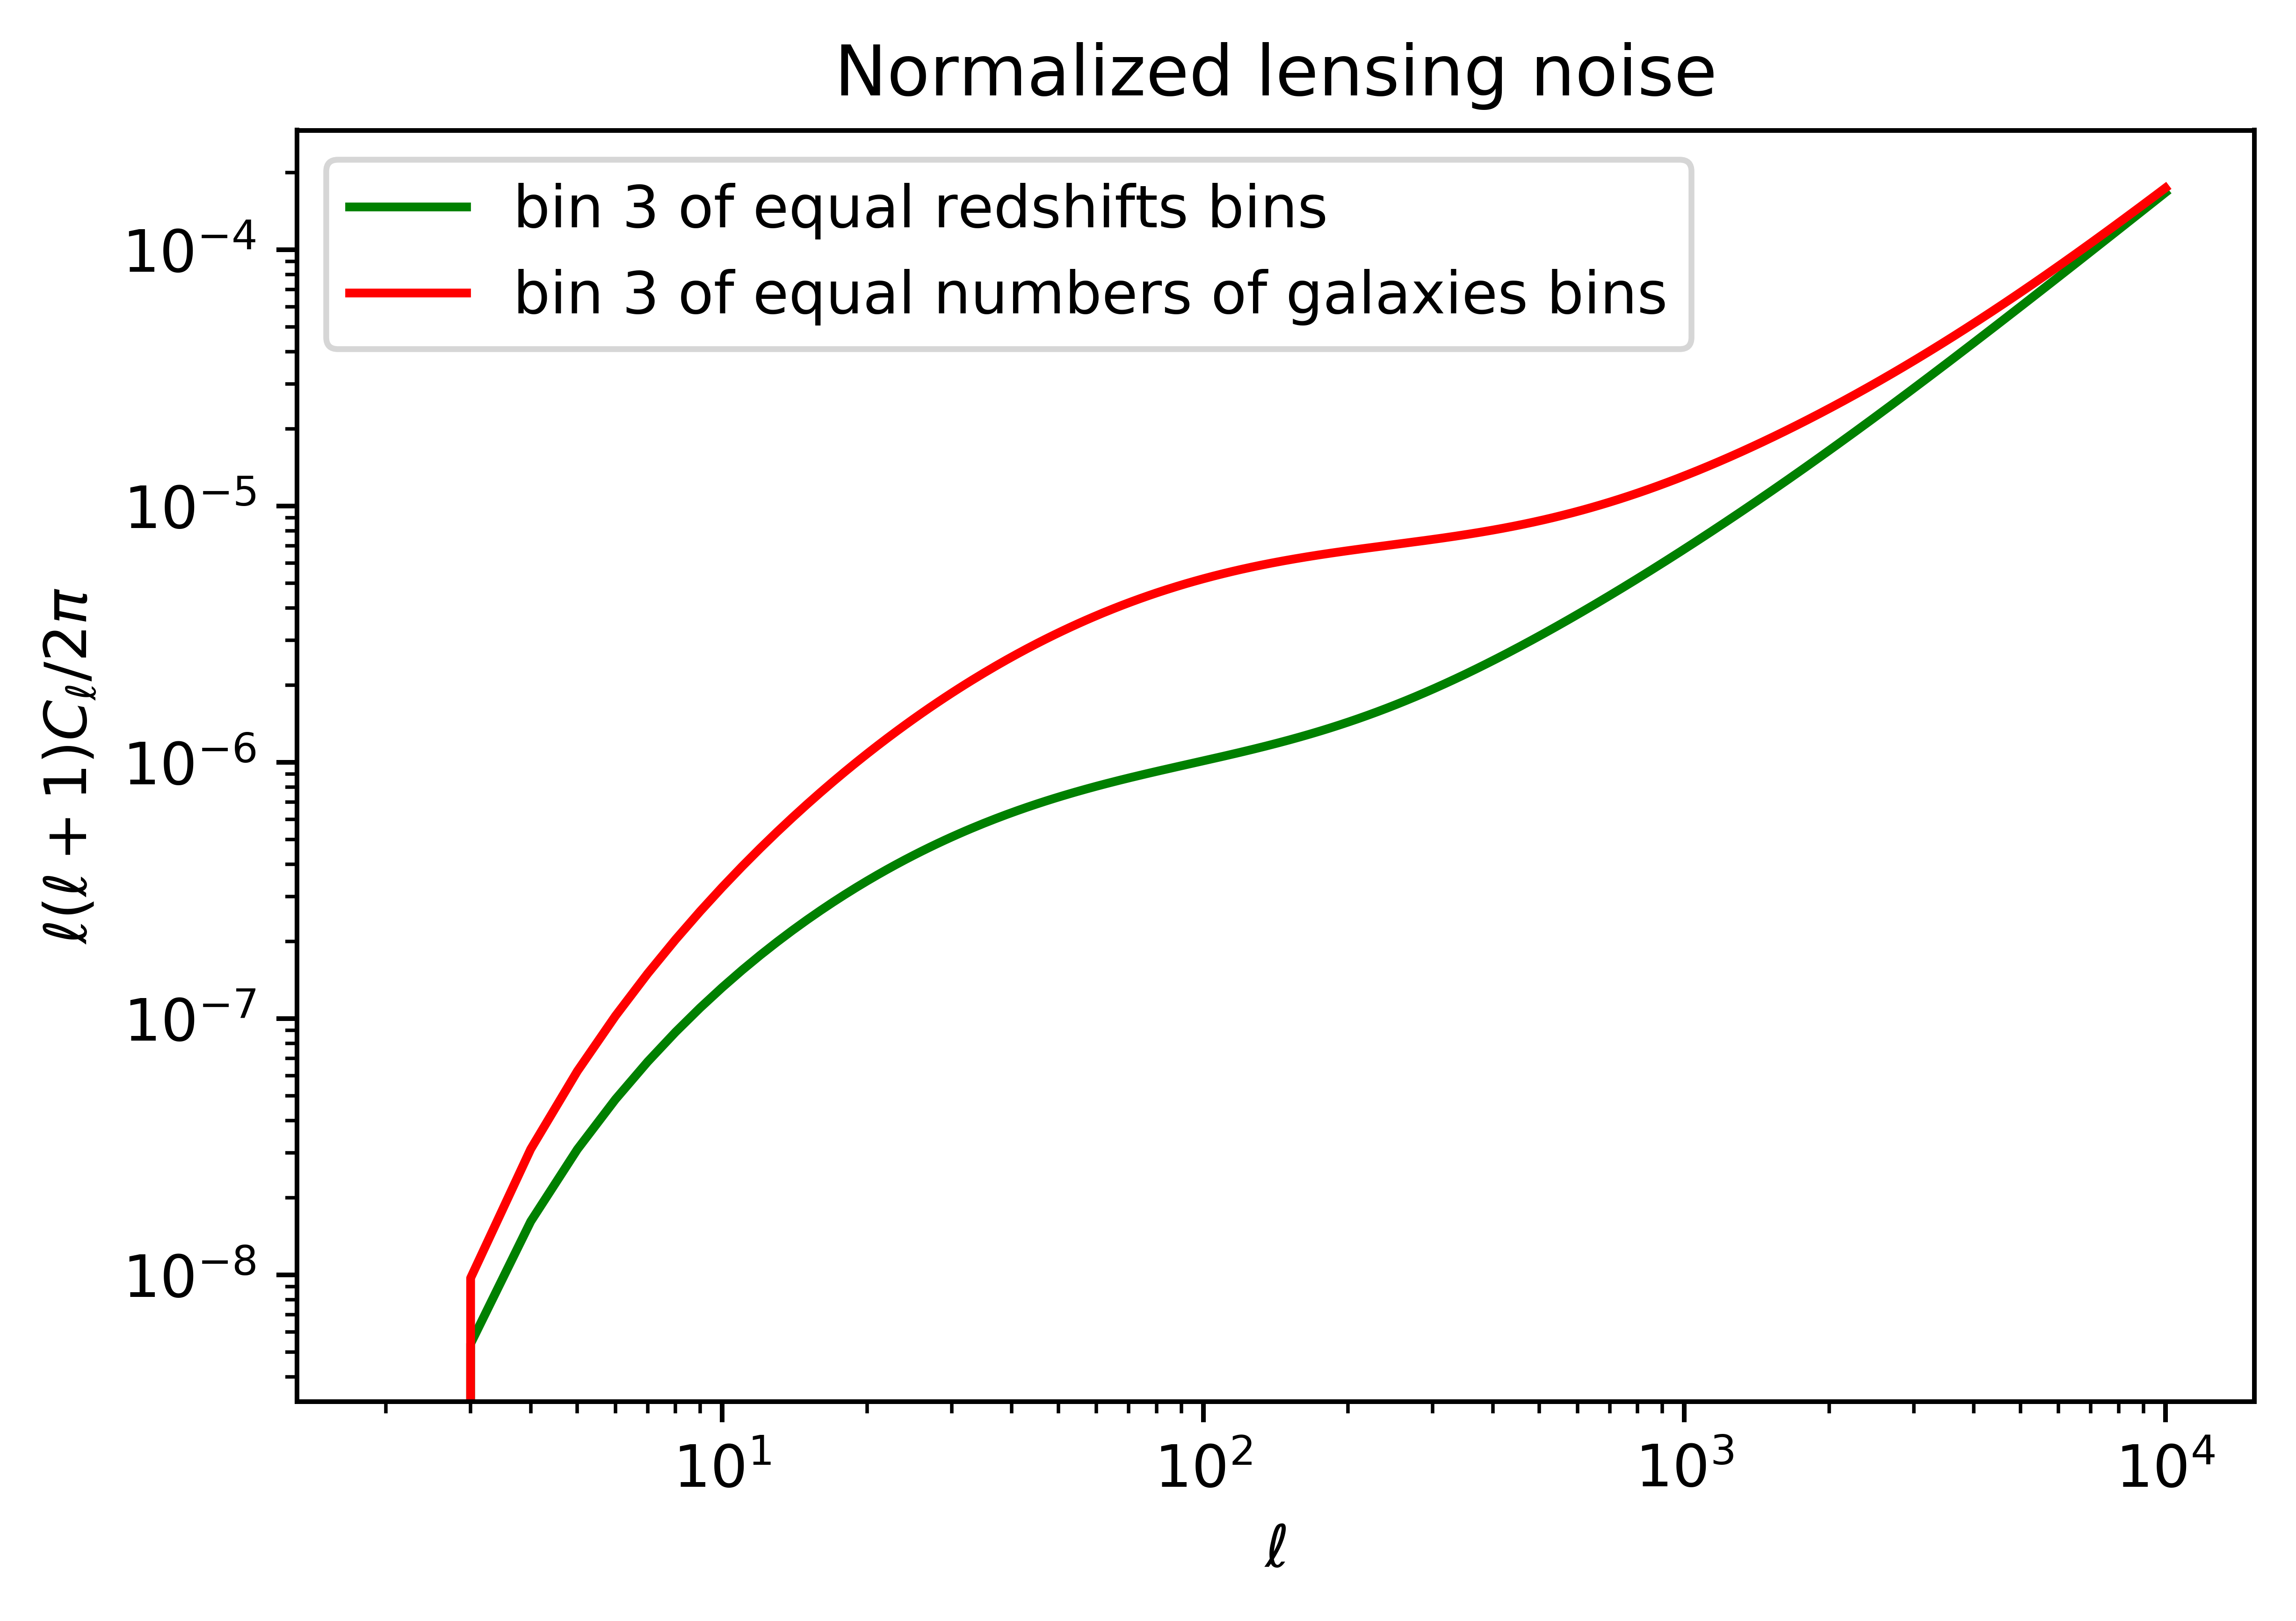

In [29]:
plt.figure()
plt.loglog(ell, normalizing(np.sqrt(cov["n_5"][:, 9, 9])), color='g', label = "bin 3 of equal redshifts bins")
plt.loglog(ell, normalizing(np.sqrt(cov["z_5"][:, 9, 9])), color='r', label = "bin 3 of equal numbers of galaxies bins")
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing noise")
plt.show() 

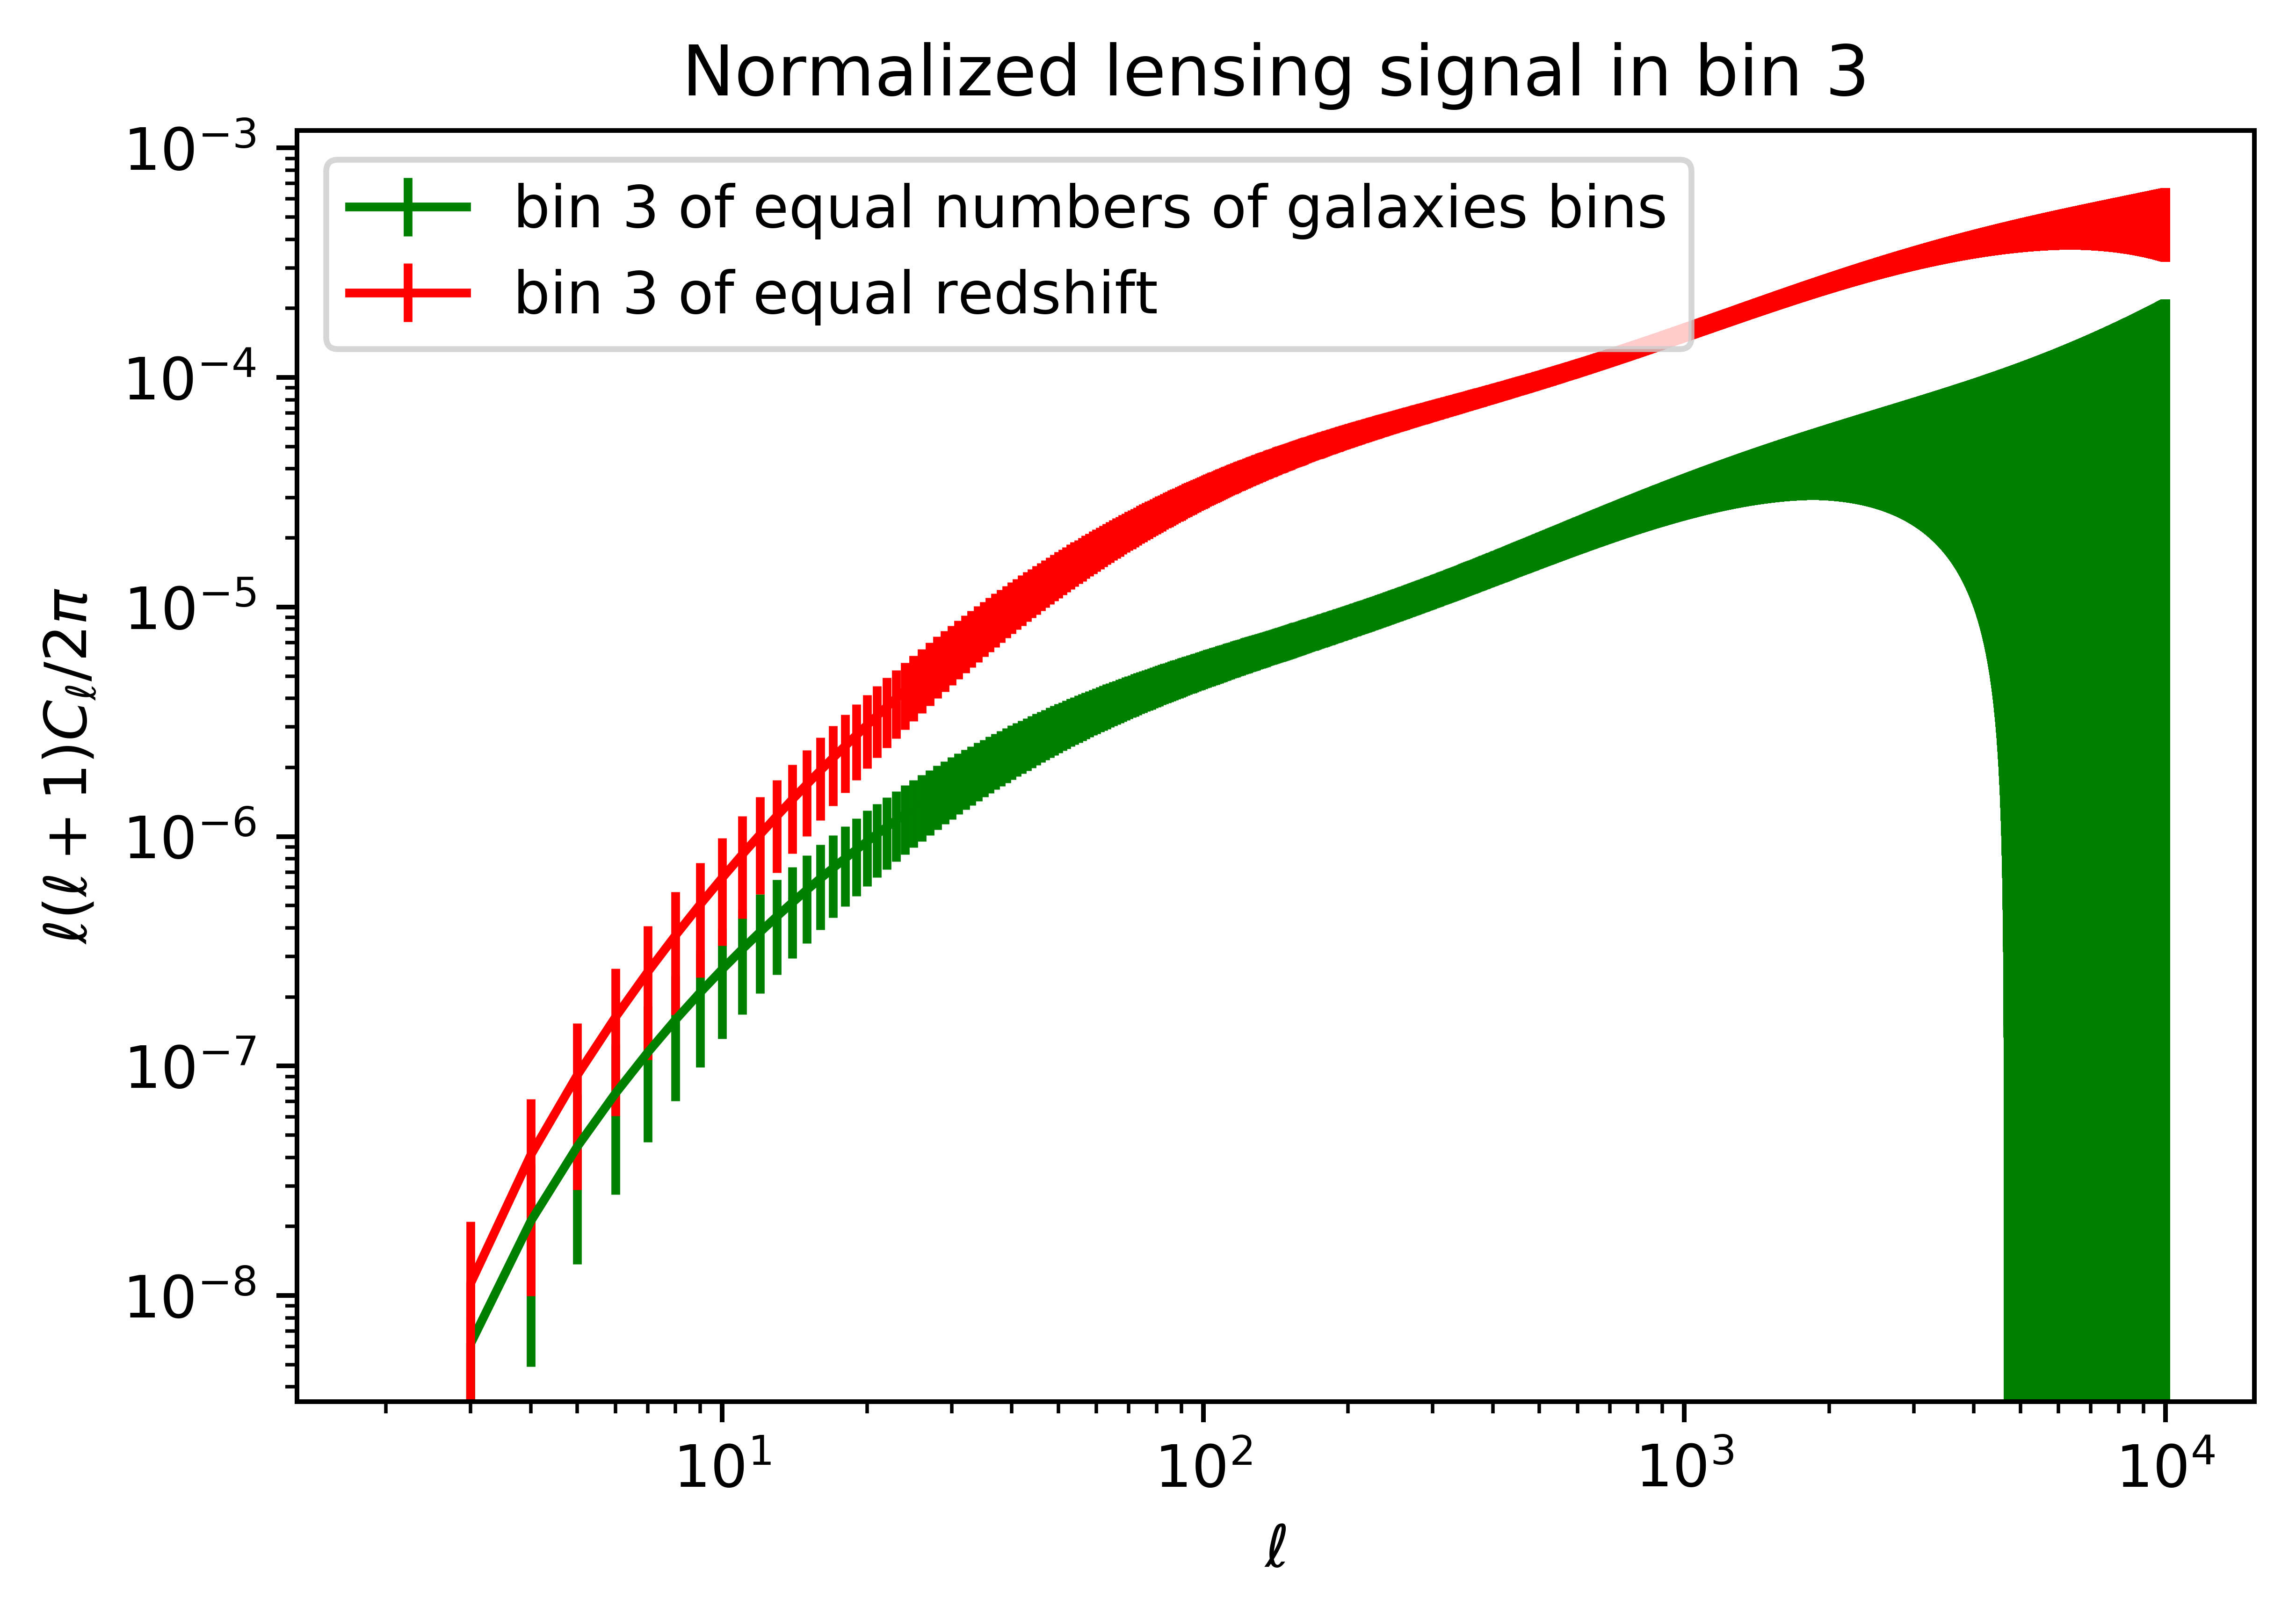

In [30]:
plt.figure()
plt.errorbar(ell, normalizing(cl["n_5"][9]), yerr = normalizing(np.sqrt(cov["n_5"][:, 9, 9])), color='g', label = "bin 3 of equal numbers of galaxies bins")
plt.errorbar(ell, normalizing(cl["z_5"][9]), yerr = normalizing(np.sqrt(cov["z_5"][:, 9, 9])), color='r', label = "bin 3 of equal redshift")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in bin 3")
plt.show() 

the third bin for equal number of galaxies has 3.6 more times of galaxies, but in lower redshifts
intuitively, more number of galaxies ==> stronger signal, and higher redshift ==> stronger signal. So we can't really quantitatively predict which bin would have higher signal
we also noticed that the noise blow up for equal galaxy bins after l=3000

In [31]:
# what if we only add up to l=3000?
def SignalToNoise_bin_3000(cl, cov):
    """calculate the signal to noise for the given cl signal, and covariance array, without binning in z"""
    stn_sq = 0
    for i in range(3000):
        stn_sq = stn_sq + cl[i]**2/cov[i]
    stn = np.sqrt(stn_sq)
    return stn

In [32]:
for i in ["z", "n"]:
    for j in [0, 5, 9, 12, 14]:
        stn["{0}_5_bin_{1}_3000".format(i,j+1)] = SignalToNoise_bin(cl = cl["{0}_5".format(i)][j], cov = cov["{0}_5".format(i)][:, j, j])

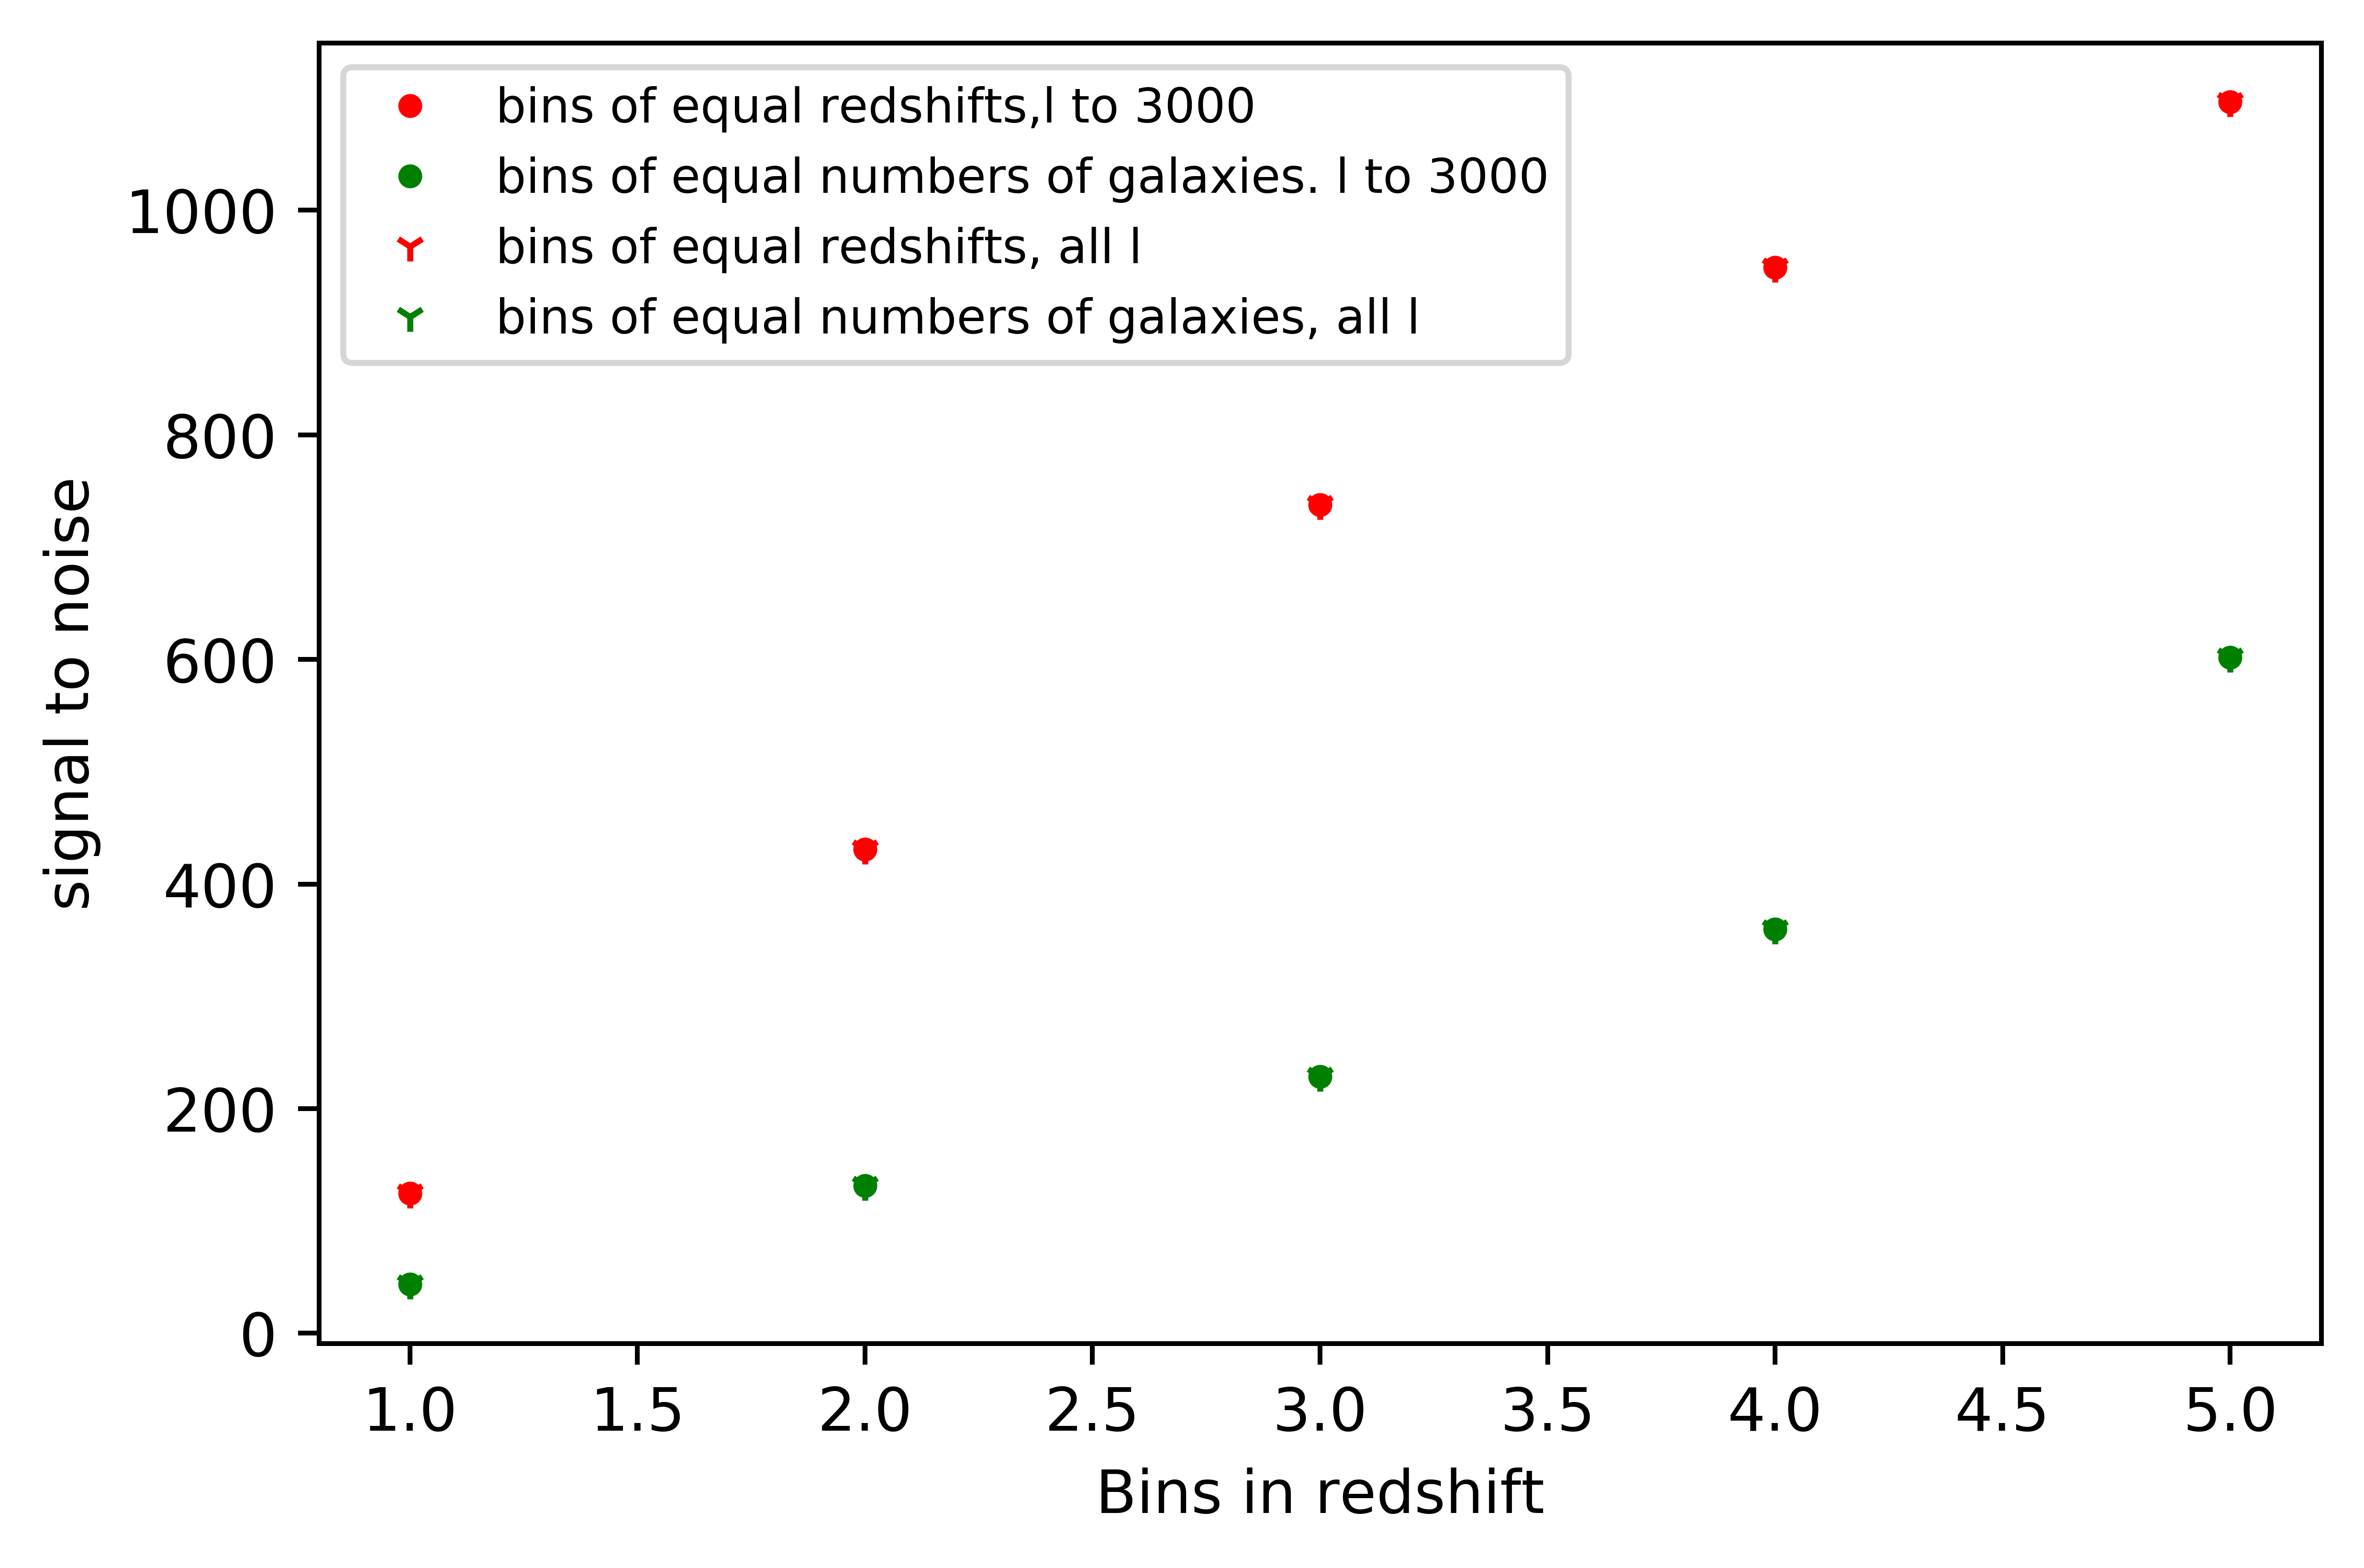

In [33]:
params = {'legend.fontsize': 8,
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.figure()
plt.plot([1, 2, 3, 4, 5], [stn["z_5_bin_1_3000"], stn["z_5_bin_6_3000"], stn["z_5_bin_10_3000"], stn["z_5_bin_13_3000"], stn["z_5_bin_15_3000"]],
         color='r', linestyle='None', marker ="o", markersize = 3.0, label = "bins of equal redshifts,l to 3000")
plt.plot([1, 2, 3, 4, 5], [stn["n_5_bin_1_3000"], stn["n_5_bin_6_3000"], stn["n_5_bin_10_3000"], stn["n_5_bin_13_3000"], stn["n_5_bin_15_3000"]],
         color='g', linestyle='None', marker ="o", markersize = 3.0, label = "bins of equal numbers of galaxies. l to 3000")
plt.plot([1, 2, 3, 4, 5], [stn["z_5_bin_1"], stn["z_5_bin_6"], stn["z_5_bin_10"], stn["z_5_bin_13"], stn["z_5_bin_15"]],
         color='r', linestyle='None', marker ="1", markersize = 5.0, label = "bins of equal redshifts, all l")
plt.plot([1, 2, 3, 4, 5], [stn["n_5_bin_1"], stn["n_5_bin_6"], stn["n_5_bin_10"], stn["n_5_bin_13"], stn["n_5_bin_15"]],
         color='g', linestyle='None', marker ="1", markersize = 5.0, label = "bins of equal numbers of galaxies, all l")
plt.xlabel("Bins in redshift")
plt.ylabel("signal to noise")
plt.legend(loc="upper left")
plt.show() 

cutting off l>3000 does not affect signal to noise, even though the noise for l>3000 is big in equal redshift bins
actually, they give almost the same value for signal to noise+

In [34]:
stn

{'z_5': 1769.747979407873,
 'n_5': 818.4592484509981,
 'z_5_bin_1': 124.68944896705639,
 'z_5_bin_6': 430.9223962741593,
 'z_5_bin_10': 737.6954515035086,
 'z_5_bin_13': 949.031144867676,
 'z_5_bin_15': 1096.4469711788372,
 'n_5_bin_1': 43.68052310619691,
 'n_5_bin_6': 131.3264521732455,
 'n_5_bin_10': 228.63766595769104,
 'n_5_bin_13': 359.85546135721165,
 'n_5_bin_15': 601.9771245900487,
 'z_5_bin_1_3000': 124.68944896705639,
 'z_5_bin_6_3000': 430.9223962741593,
 'z_5_bin_10_3000': 737.6954515035086,
 'z_5_bin_13_3000': 949.031144867676,
 'z_5_bin_15_3000': 1096.4469711788372,
 'n_5_bin_1_3000': 43.68052310619691,
 'n_5_bin_6_3000': 131.3264521732455,
 'n_5_bin_10_3000': 228.63766595769104,
 'n_5_bin_13_3000': 359.85546135721165,
 'n_5_bin_15_3000': 601.9771245900487}

In [35]:
print(np.sum(sliced_dndz["n_5"]["bin_4"][:,1])/np.sum(sliced_dndz["z_5"]["bin_4"][:,1]))

146.1945823329246


let's see what happen in the last tomographic bin
notice that the last bin for equal number of galaxies has 146.2 times more galaxy than the last bin of equal redshift
the last bin for equal number of galaxies has redshift from 1.12 to 4.00, and for equal redshift bin, it covers redshift from 3.21 to 4.00
intuitively, the signal for the last equal number of galaxy bin should be much higher than the last equal redshift bins, since the last equal galaxy bin includes all the galaxies in the equal redshift bin, as well as galaxies in lower redshifts

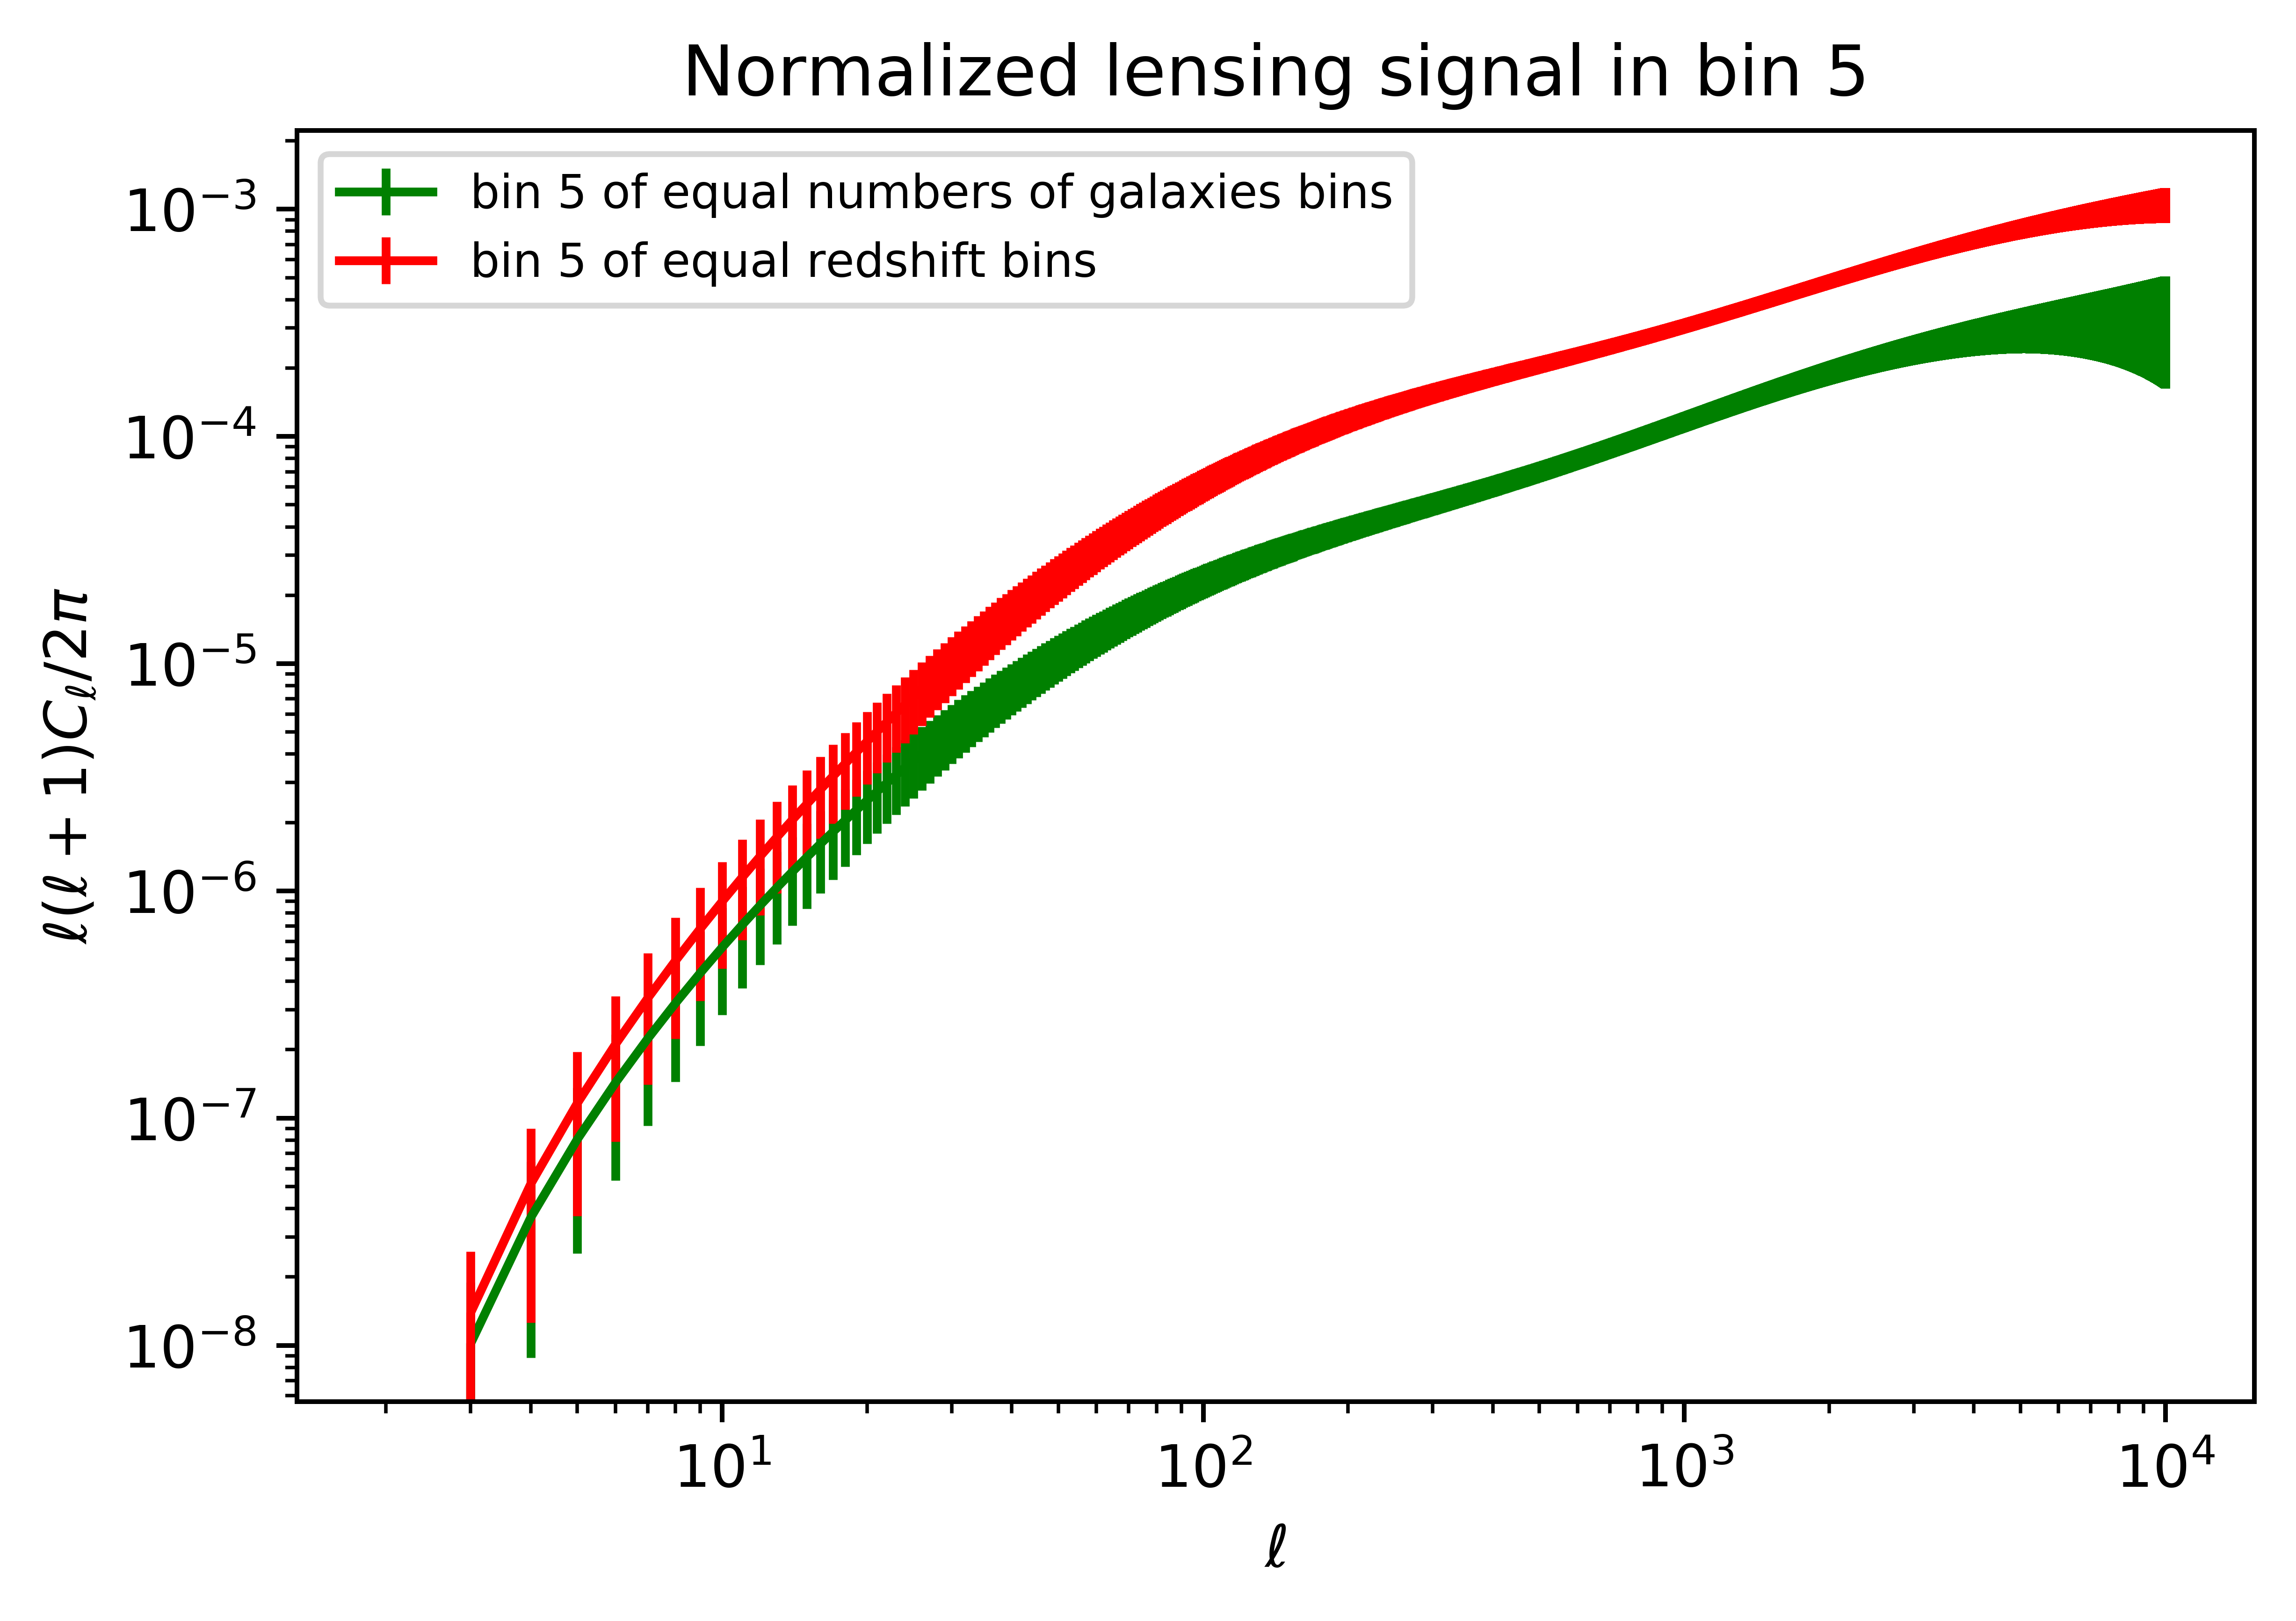

In [36]:
plt.figure()
plt.errorbar(ell, normalizing(cl["n_5"][14]), yerr = normalizing(np.sqrt(cov["n_5"][:, 14, 14])), color='g', label = "bin 5 of equal numbers of galaxies bins")
plt.errorbar(ell, normalizing(cl["z_5"][14]), yerr = normalizing(np.sqrt(cov["z_5"][:, 14, 14])), color='r', label = "bin 5 of equal redshift bins")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in bin 5")
plt.show() 

no....that doesn't seem like what we expected

how about bin 1? bin 1 of equal redshifts includes all galaxies in bins 1,2,and 3 of equal galaxy number. we should expect that bin 1 of equal redshifts has higher signal than bin 1 of equal galaxy number

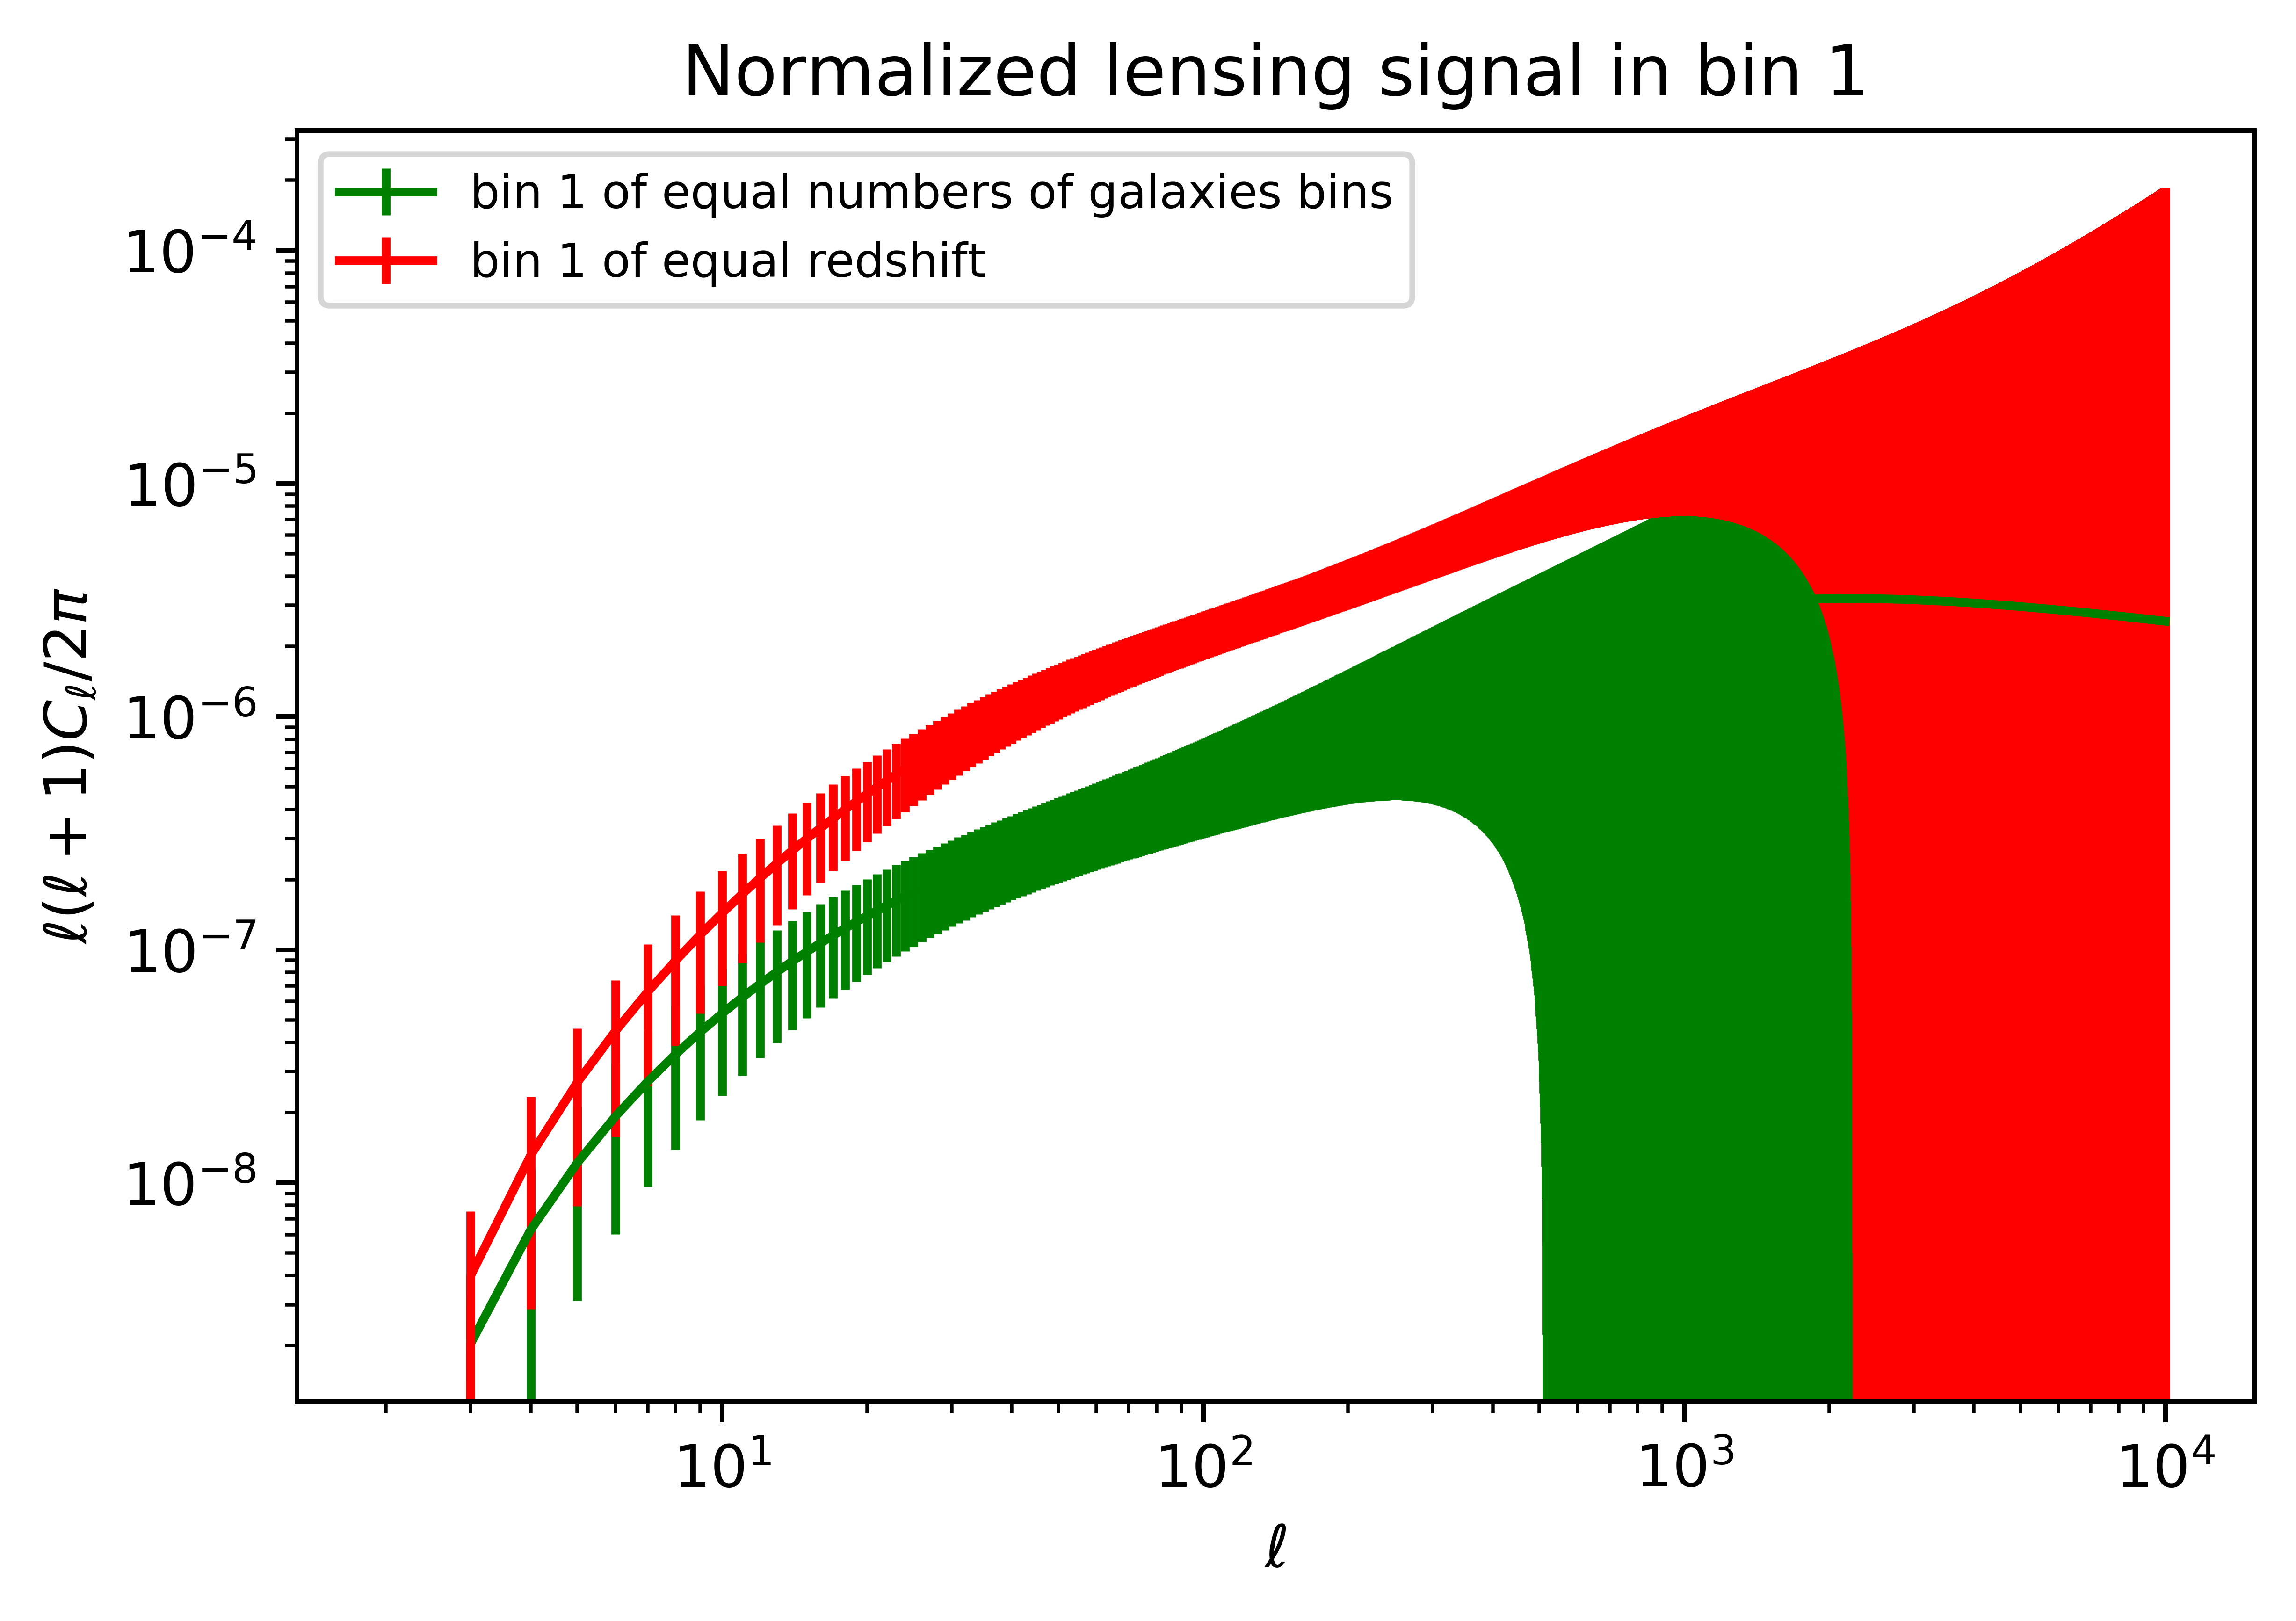

In [37]:
plt.figure()
plt.errorbar(ell, normalizing(cl["n_5"][0]), yerr = normalizing(np.sqrt(cov["n_5"][:, 0, 0])), color='g', label = "bin 1 of equal numbers of galaxies bins")
plt.errorbar(ell, normalizing(cl["z_5"][0]), yerr = normalizing(np.sqrt(cov["z_5"][:, 0, 0])), color='r', label = "bin 1 of equal redshift")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in bin 1")
plt.show() 

well. the noise blow up quickly for equal galaxy bins
let's check what's going on with the cls?

In [38]:
dndz1[:200]

array([[1.00000000e-03, 1.04399724e+03],
       [1.10225564e-02, 1.12109166e+05],
       [2.10451128e-02, 3.71367220e+05],
       [3.10676692e-02, 7.42782003e+05],
       [4.10902256e-02, 1.19968246e+06],
       [5.11127820e-02, 1.72117113e+06],
       [6.11353383e-02, 2.29045161e+06],
       [7.11578947e-02, 2.89382964e+06],
       [8.11804511e-02, 3.52004465e+06],
       [9.12030075e-02, 4.15979133e+06],
       [1.01225564e-01, 4.80536177e+06],
       [1.11248120e-01, 5.45036902e+06],
       [1.21270677e-01, 6.08952862e+06],
       [1.31293233e-01, 6.71848274e+06],
       [1.41315789e-01, 7.33365662e+06],
       [1.51338346e-01, 7.93214000e+06],
       [1.61360902e-01, 8.51158826e+06],
       [1.71383459e-01, 9.07013941e+06],
       [1.81406015e-01, 9.60634387e+06],
       [1.91428571e-01, 1.01191048e+07],
       [2.01451128e-01, 1.06076269e+07],
       [2.11473684e-01, 1.10713731e+07],
       [2.21496241e-01, 1.15100266e+07],
       [2.31518797e-01, 1.19234583e+07],
       [2.415413

In [41]:
for n, dndz in enumerate(sliced_dndz["z_5"].values()):
    print(n, dndz[:, 1].shape)

0 (79,)
1 (80,)
2 (80,)
3 (80,)
4 (80,)


In [42]:
for n, dndz in enumerate(sliced_dndz["n_5"].values()):
    print(n, dndz[:, 1].shape)

0 (35,)
1 (19,)
2 (23,)
3 (34,)
4 (288,)


In [43]:
sliced_dndz["z_5"]

{'bin_0': array([[1.10225564e-02, 1.12109166e+05],
        [2.10451128e-02, 3.71367220e+05],
        [3.10676692e-02, 7.42782003e+05],
        [4.10902256e-02, 1.19968246e+06],
        [5.11127820e-02, 1.72117113e+06],
        [6.11353383e-02, 2.29045161e+06],
        [7.11578947e-02, 2.89382964e+06],
        [8.11804511e-02, 3.52004465e+06],
        [9.12030075e-02, 4.15979133e+06],
        [1.01225564e-01, 4.80536177e+06],
        [1.11248120e-01, 5.45036902e+06],
        [1.21270677e-01, 6.08952862e+06],
        [1.31293233e-01, 6.71848274e+06],
        [1.41315789e-01, 7.33365662e+06],
        [1.51338346e-01, 7.93214000e+06],
        [1.61360902e-01, 8.51158826e+06],
        [1.71383459e-01, 9.07013941e+06],
        [1.81406015e-01, 9.60634387e+06],
        [1.91428571e-01, 1.01191048e+07],
        [2.01451128e-01, 1.06076269e+07],
        [2.11473684e-01, 1.10713731e+07],
        [2.21496241e-01, 1.15100266e+07],
        [2.31518797e-01, 1.19234583e+07],
        [2.41541353e-01, 

In [44]:
sliced_dndz["n_5"]

{'bin_0': array([[1.00000000e-03, 1.04399724e+03],
        [1.10225564e-02, 1.12109166e+05],
        [2.10451128e-02, 3.71367220e+05],
        [3.10676692e-02, 7.42782003e+05],
        [4.10902256e-02, 1.19968246e+06],
        [5.11127820e-02, 1.72117113e+06],
        [6.11353383e-02, 2.29045161e+06],
        [7.11578947e-02, 2.89382964e+06],
        [8.11804511e-02, 3.52004465e+06],
        [9.12030075e-02, 4.15979133e+06],
        [1.01225564e-01, 4.80536177e+06],
        [1.11248120e-01, 5.45036902e+06],
        [1.21270677e-01, 6.08952862e+06],
        [1.31293233e-01, 6.71848274e+06],
        [1.41315789e-01, 7.33365662e+06],
        [1.51338346e-01, 7.93214000e+06],
        [1.61360902e-01, 8.51158826e+06],
        [1.71383459e-01, 9.07013941e+06],
        [1.81406015e-01, 9.60634387e+06],
        [1.91428571e-01, 1.01191048e+07],
        [2.01451128e-01, 1.06076269e+07],
        [2.11473684e-01, 1.10713731e+07],
        [2.21496241e-01, 1.15100266e+07],
        [2.31518797e-01, 

In [46]:
dndz_cut1_long = dndz1[1:80]
dndz_cut1_short = dndz1[:35]

In [47]:
lens_1long = ccl.WeakLensingTracer(cosmo, dndz=(dndz_cut1_long[:,0], dndz_cut1_long[:,1]))
lens_1short = ccl.WeakLensingTracer(cosmo, dndz=(dndz_cut1_short[:,0], dndz_cut1_short[:,1]))
cl_1long = ccl.angular_cl(cosmo, lens_1long, lens_1long, ell)
cl_1short = ccl.angular_cl(cosmo, lens_1short, lens_1short, ell)

In [48]:
cov_1long = getCovMat(fsky=0.4, n_bins=1, cl=cl_1long, ell=ell, numdenPerStr=num_den_per_str)
cov_1short = getCovMat(fsky=0.4, n_bins=1, cl=cl_1short, ell=ell, numdenPerStr=num_den_per_str)

In [50]:
cov_1short[:,0,0].shape

(9999,)

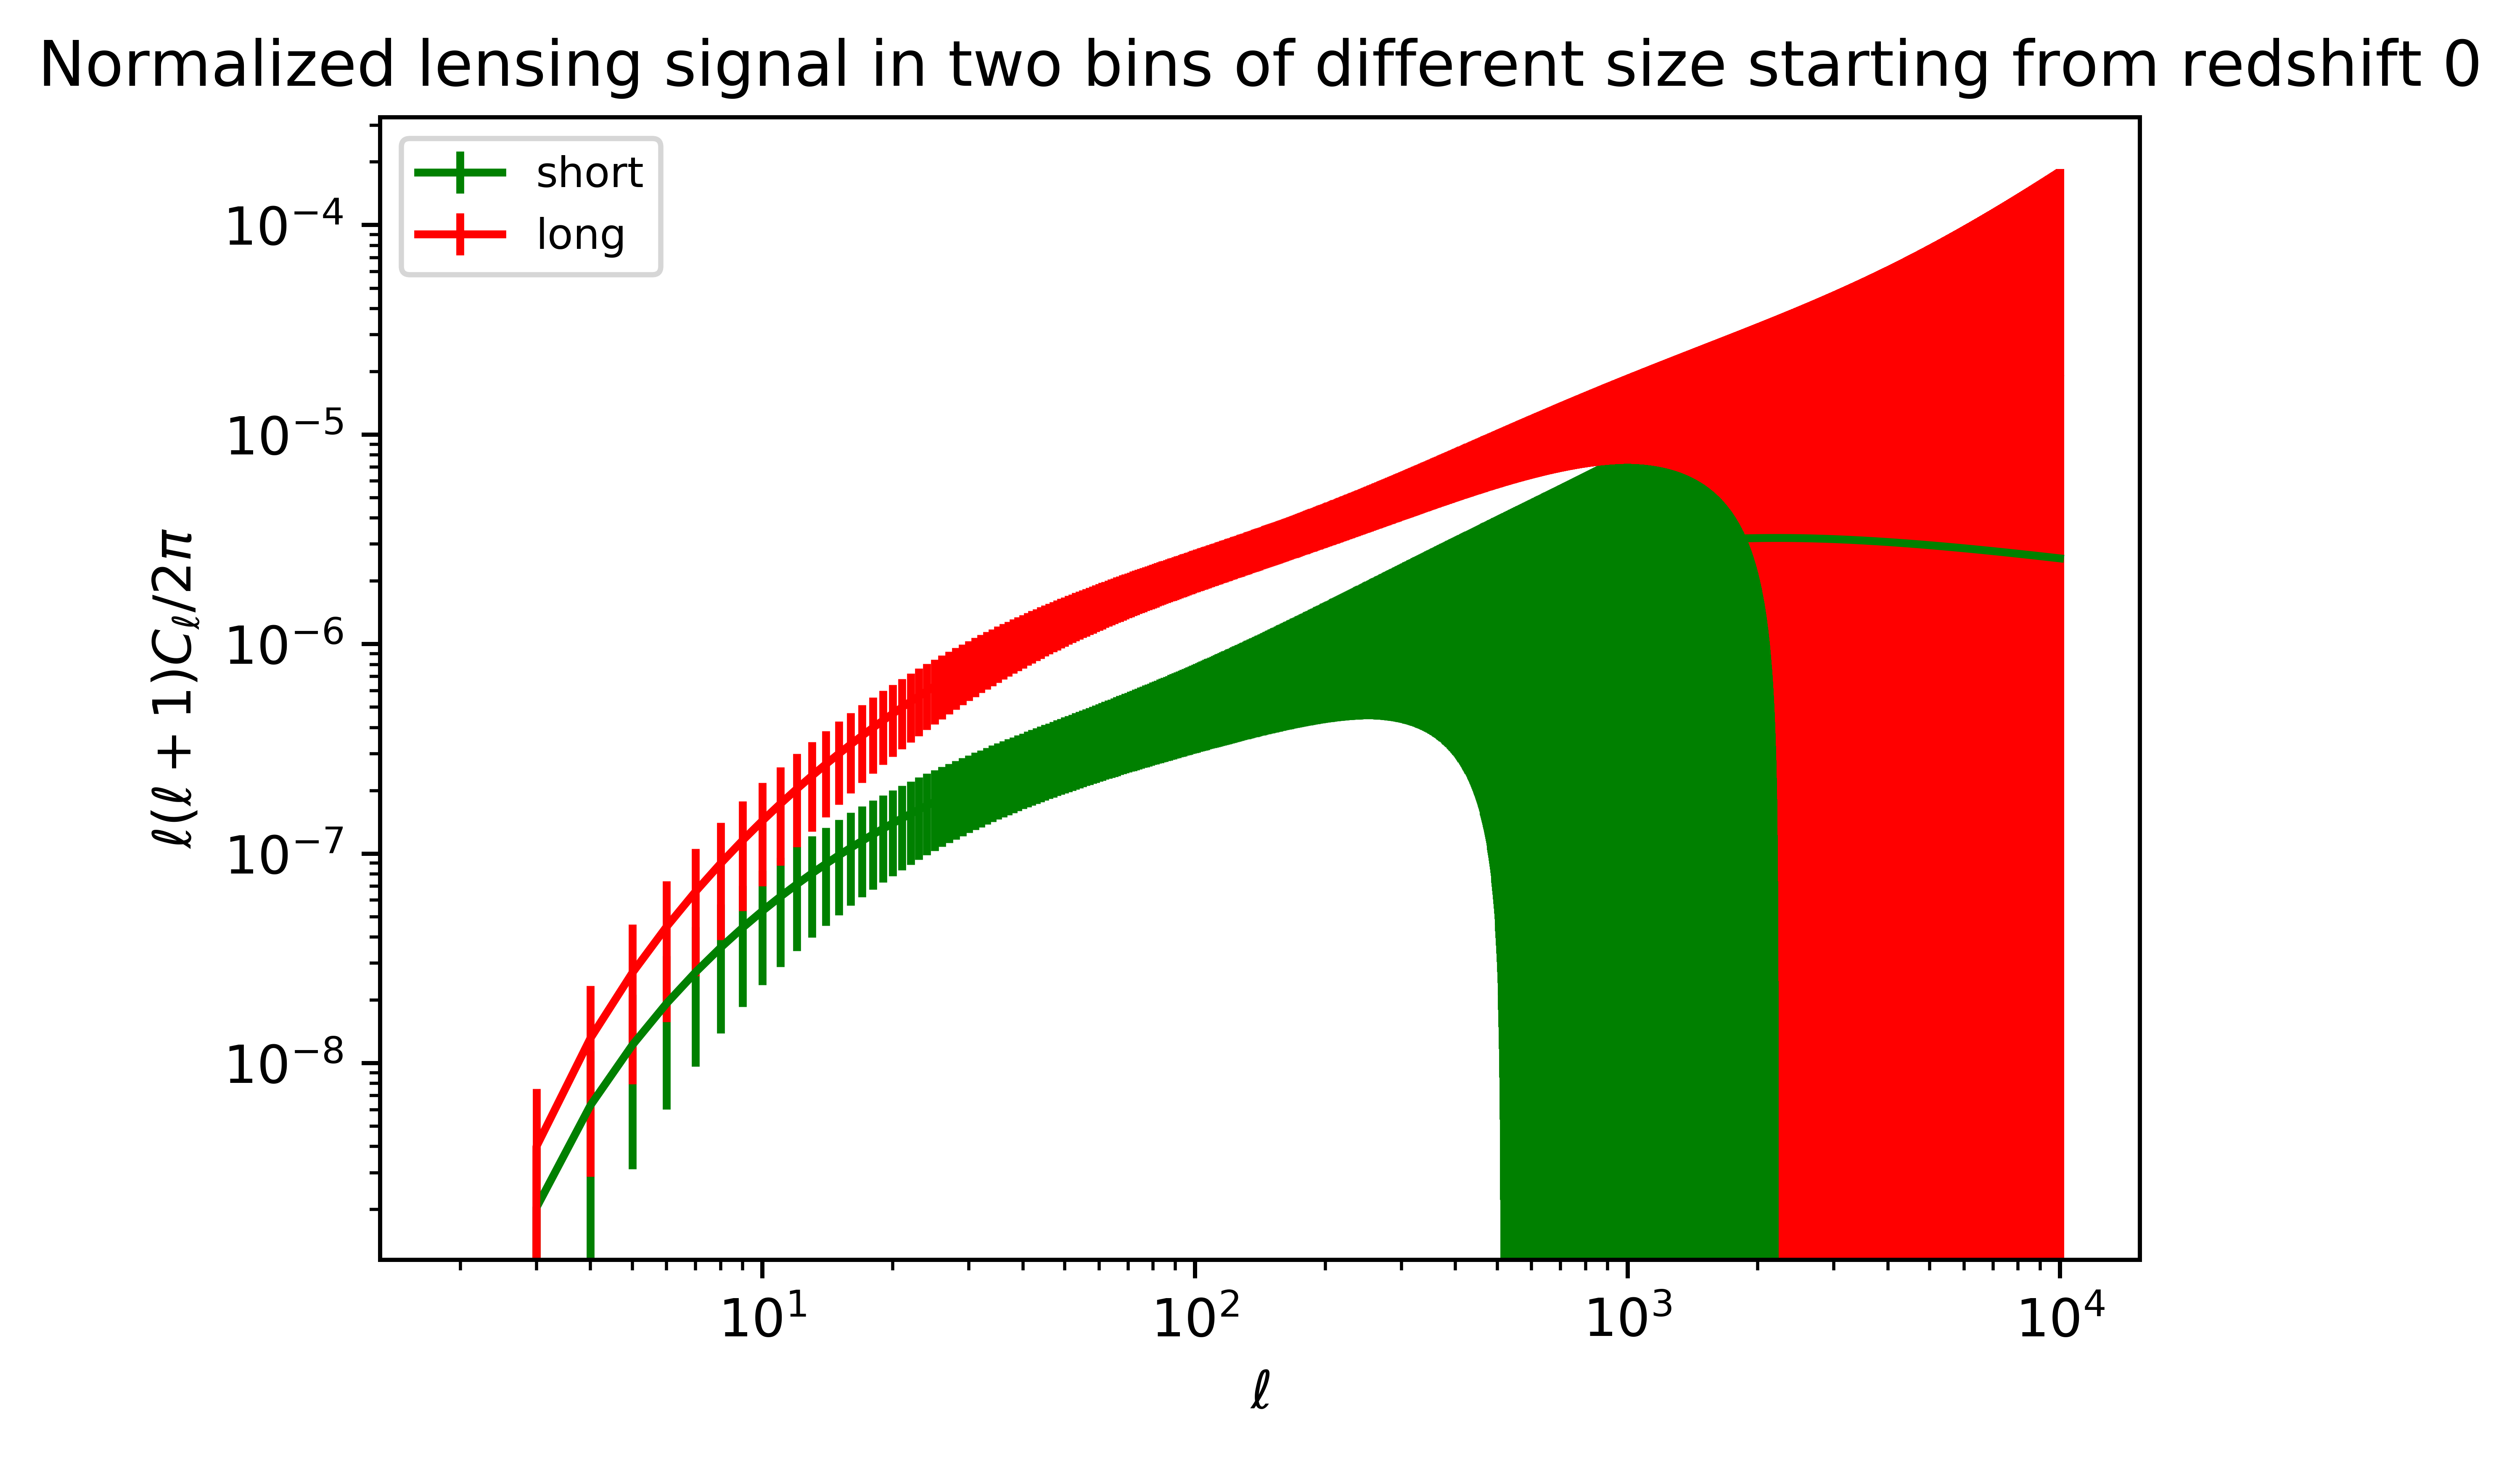

In [57]:
plt.figure()
plt.errorbar(ell, normalizing(cl_1short), yerr = normalizing(np.sqrt(cov_1short)), color='g', label = "short")
plt.errorbar(ell, normalizing(cl_1long), yerr = normalizing(np.sqrt(cov_1long)), color='r', label = "long")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in two bins of different size starting from redshift 0")
plt.show() 

this looks like the same result as in bin 1, the long bin correspond to bin1 of equal redshift, and the short bin correspond to bin 1 of equal galaxy number

In [55]:
dndz_cut5_short = dndz1[-80:]
dndz_cut5_long =dndz1[-288:]

In [56]:
lens_5long = ccl.WeakLensingTracer(cosmo, dndz=(dndz_cut5_long[:,0], dndz_cut5_long[:,1]))
lens_5short = ccl.WeakLensingTracer(cosmo, dndz=(dndz_cut5_short[:,0], dndz_cut5_short[:,1]))
cl_5long = ccl.angular_cl(cosmo, lens_5long, lens_5long, ell)
cl_5short = ccl.angular_cl(cosmo, lens_5short, lens_5short, ell)
cov_5long = getCovMat(fsky=0.4, n_bins=1, cl=cl_5long, ell=ell, numdenPerStr=num_den_per_str)
cov_5short = getCovMat(fsky=0.4, n_bins=1, cl=cl_5short, ell=ell, numdenPerStr=num_den_per_str)

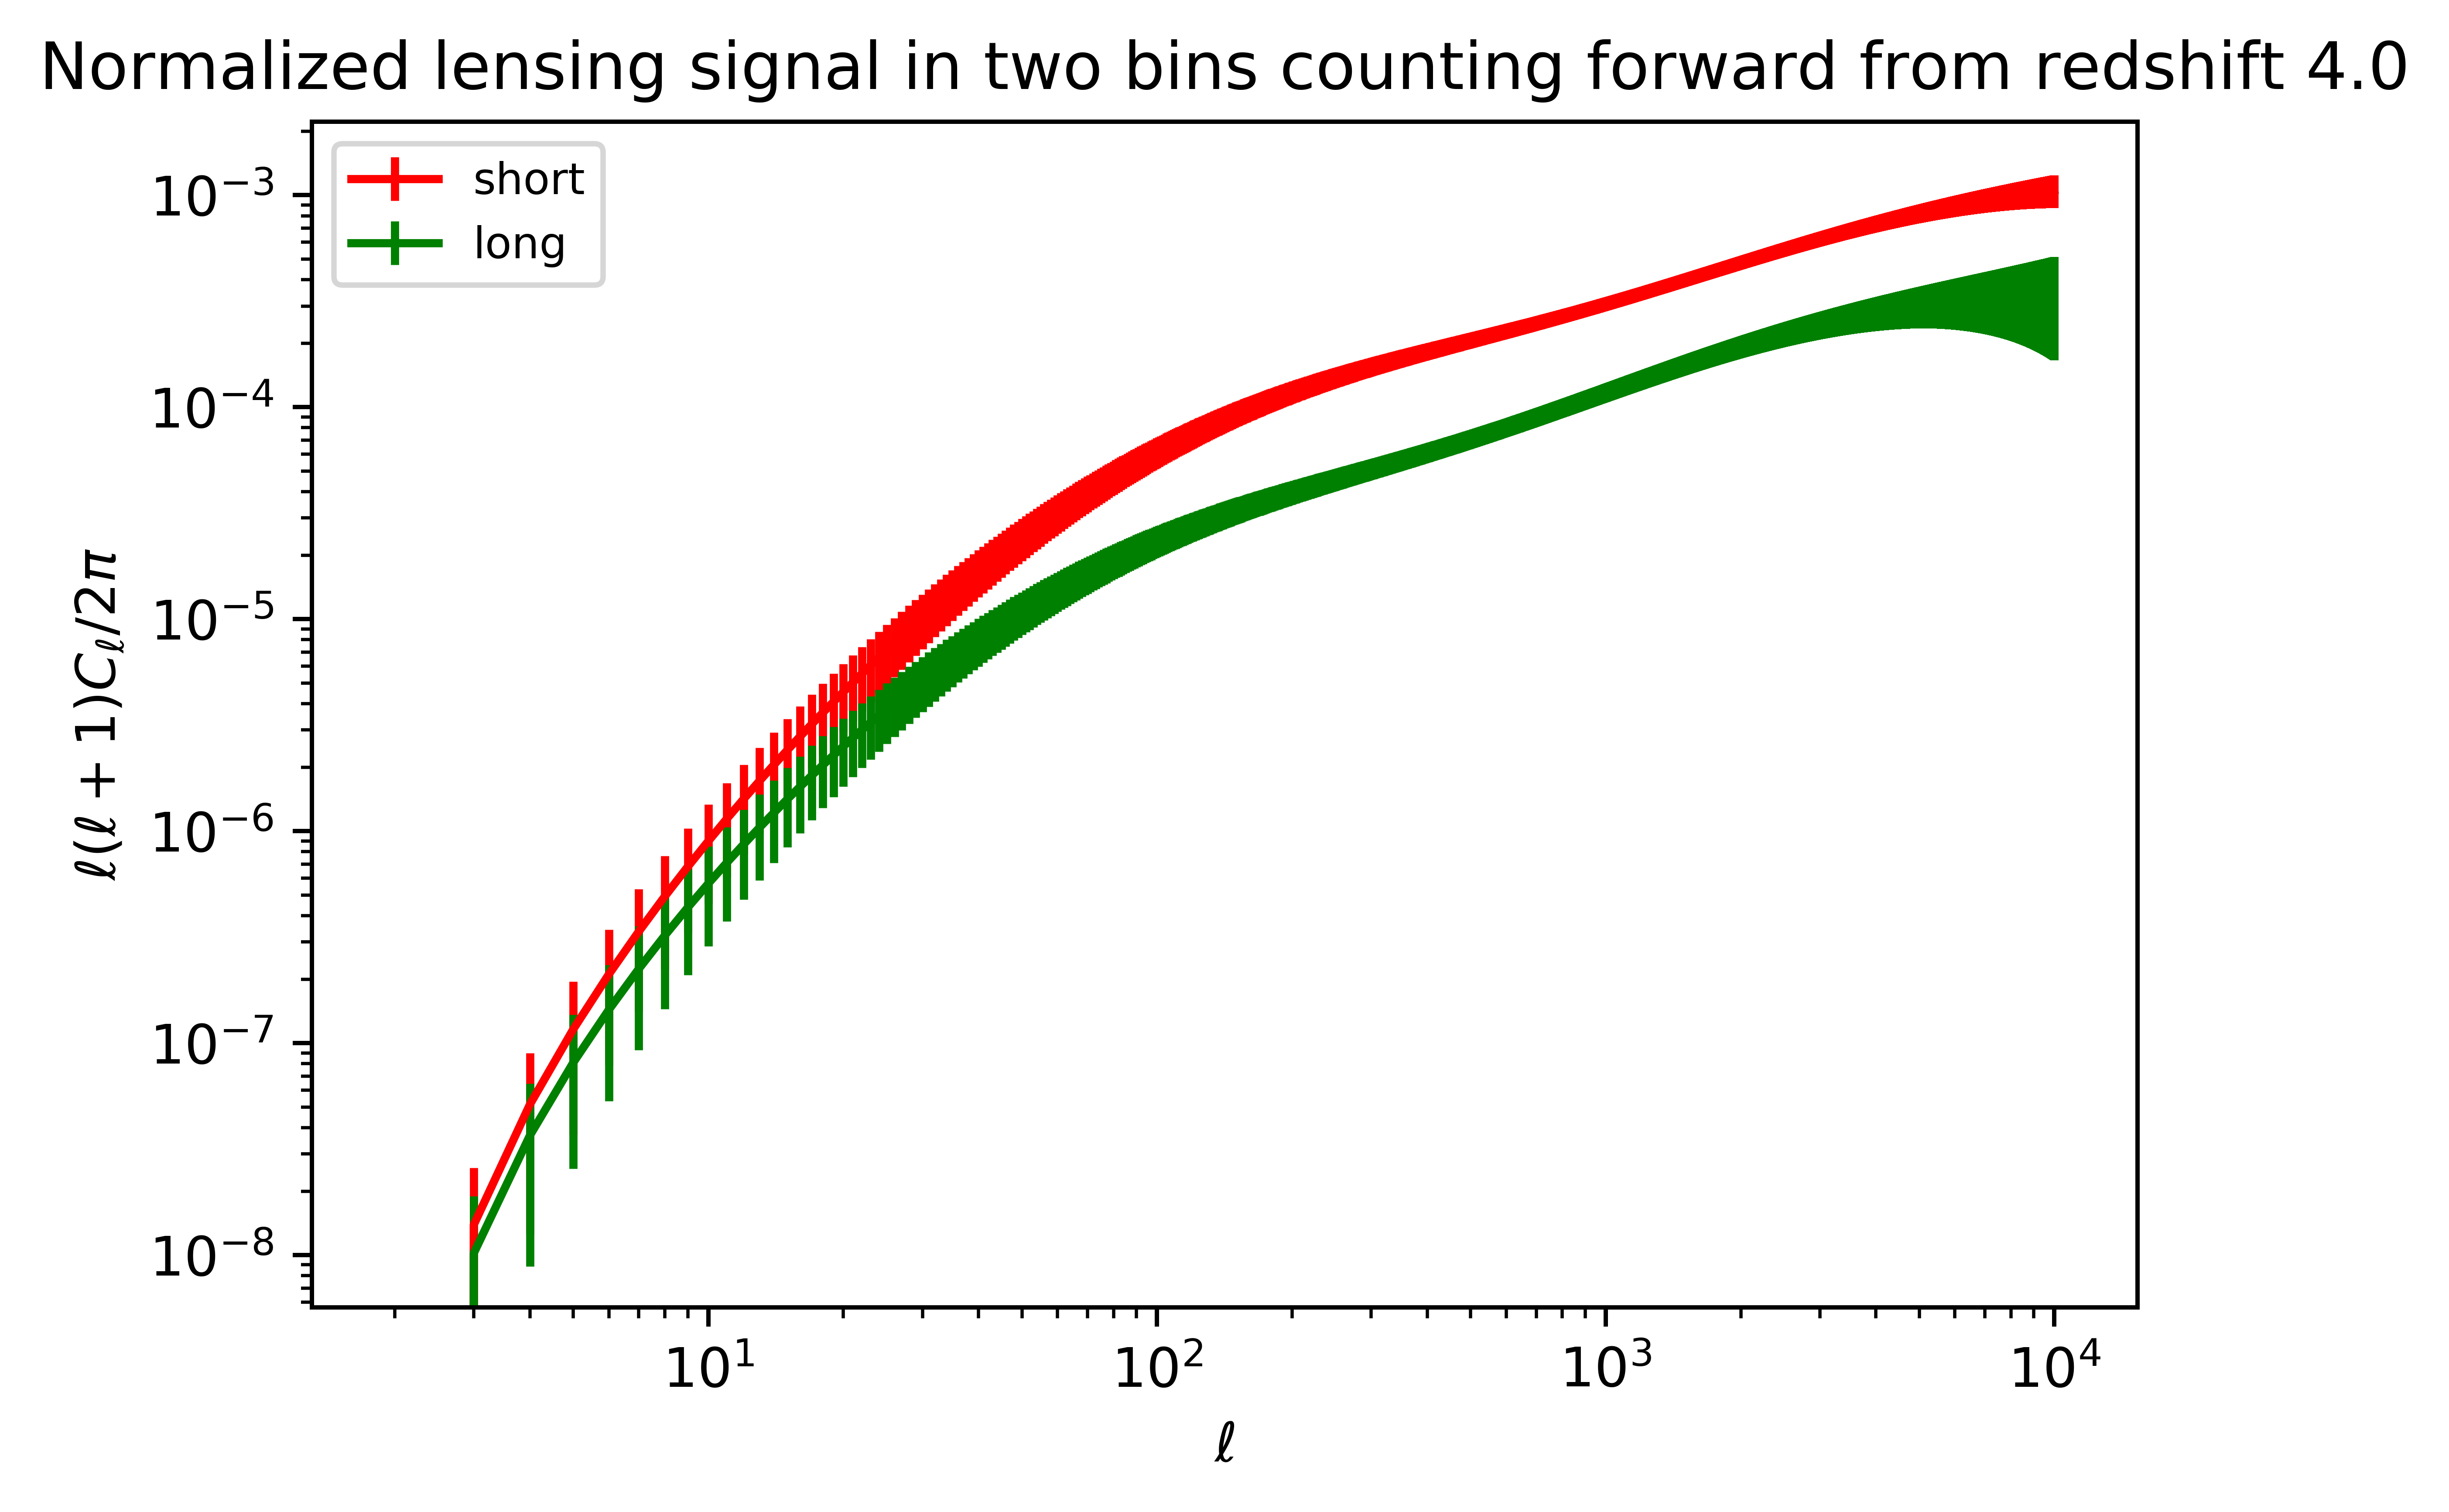

In [58]:
plt.figure()
plt.errorbar(ell, normalizing(cl_5short), yerr = normalizing(np.sqrt(cov_5short)), color='r', label = "short")
plt.errorbar(ell, normalizing(cl_5long), yerr = normalizing(np.sqrt(cov_5long)), color='g', label = "long")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in two bins counting forward from redshift 4.0")
plt.show() 

look the same as in bin 5....so this doesn't make sense

how about we consider all last three bins in equal redshift (which would cover 240 dndz, less than 288 dndz for the last bin of equal galaxy number) and compare it to the last bin of equal galaxy number?

In [60]:
dndz_cut345_short = dndz1[-240:]
lens_345short = ccl.WeakLensingTracer(cosmo, dndz=(dndz_cut345_short[:,0], dndz_cut345_short[:,1]))
cl_345short = ccl.angular_cl(cosmo, lens_345short, lens_345short, ell)
cov_345short = getCovMat(fsky=0.4, n_bins=1, cl=cl_345short, ell=ell, numdenPerStr=num_den_per_str)

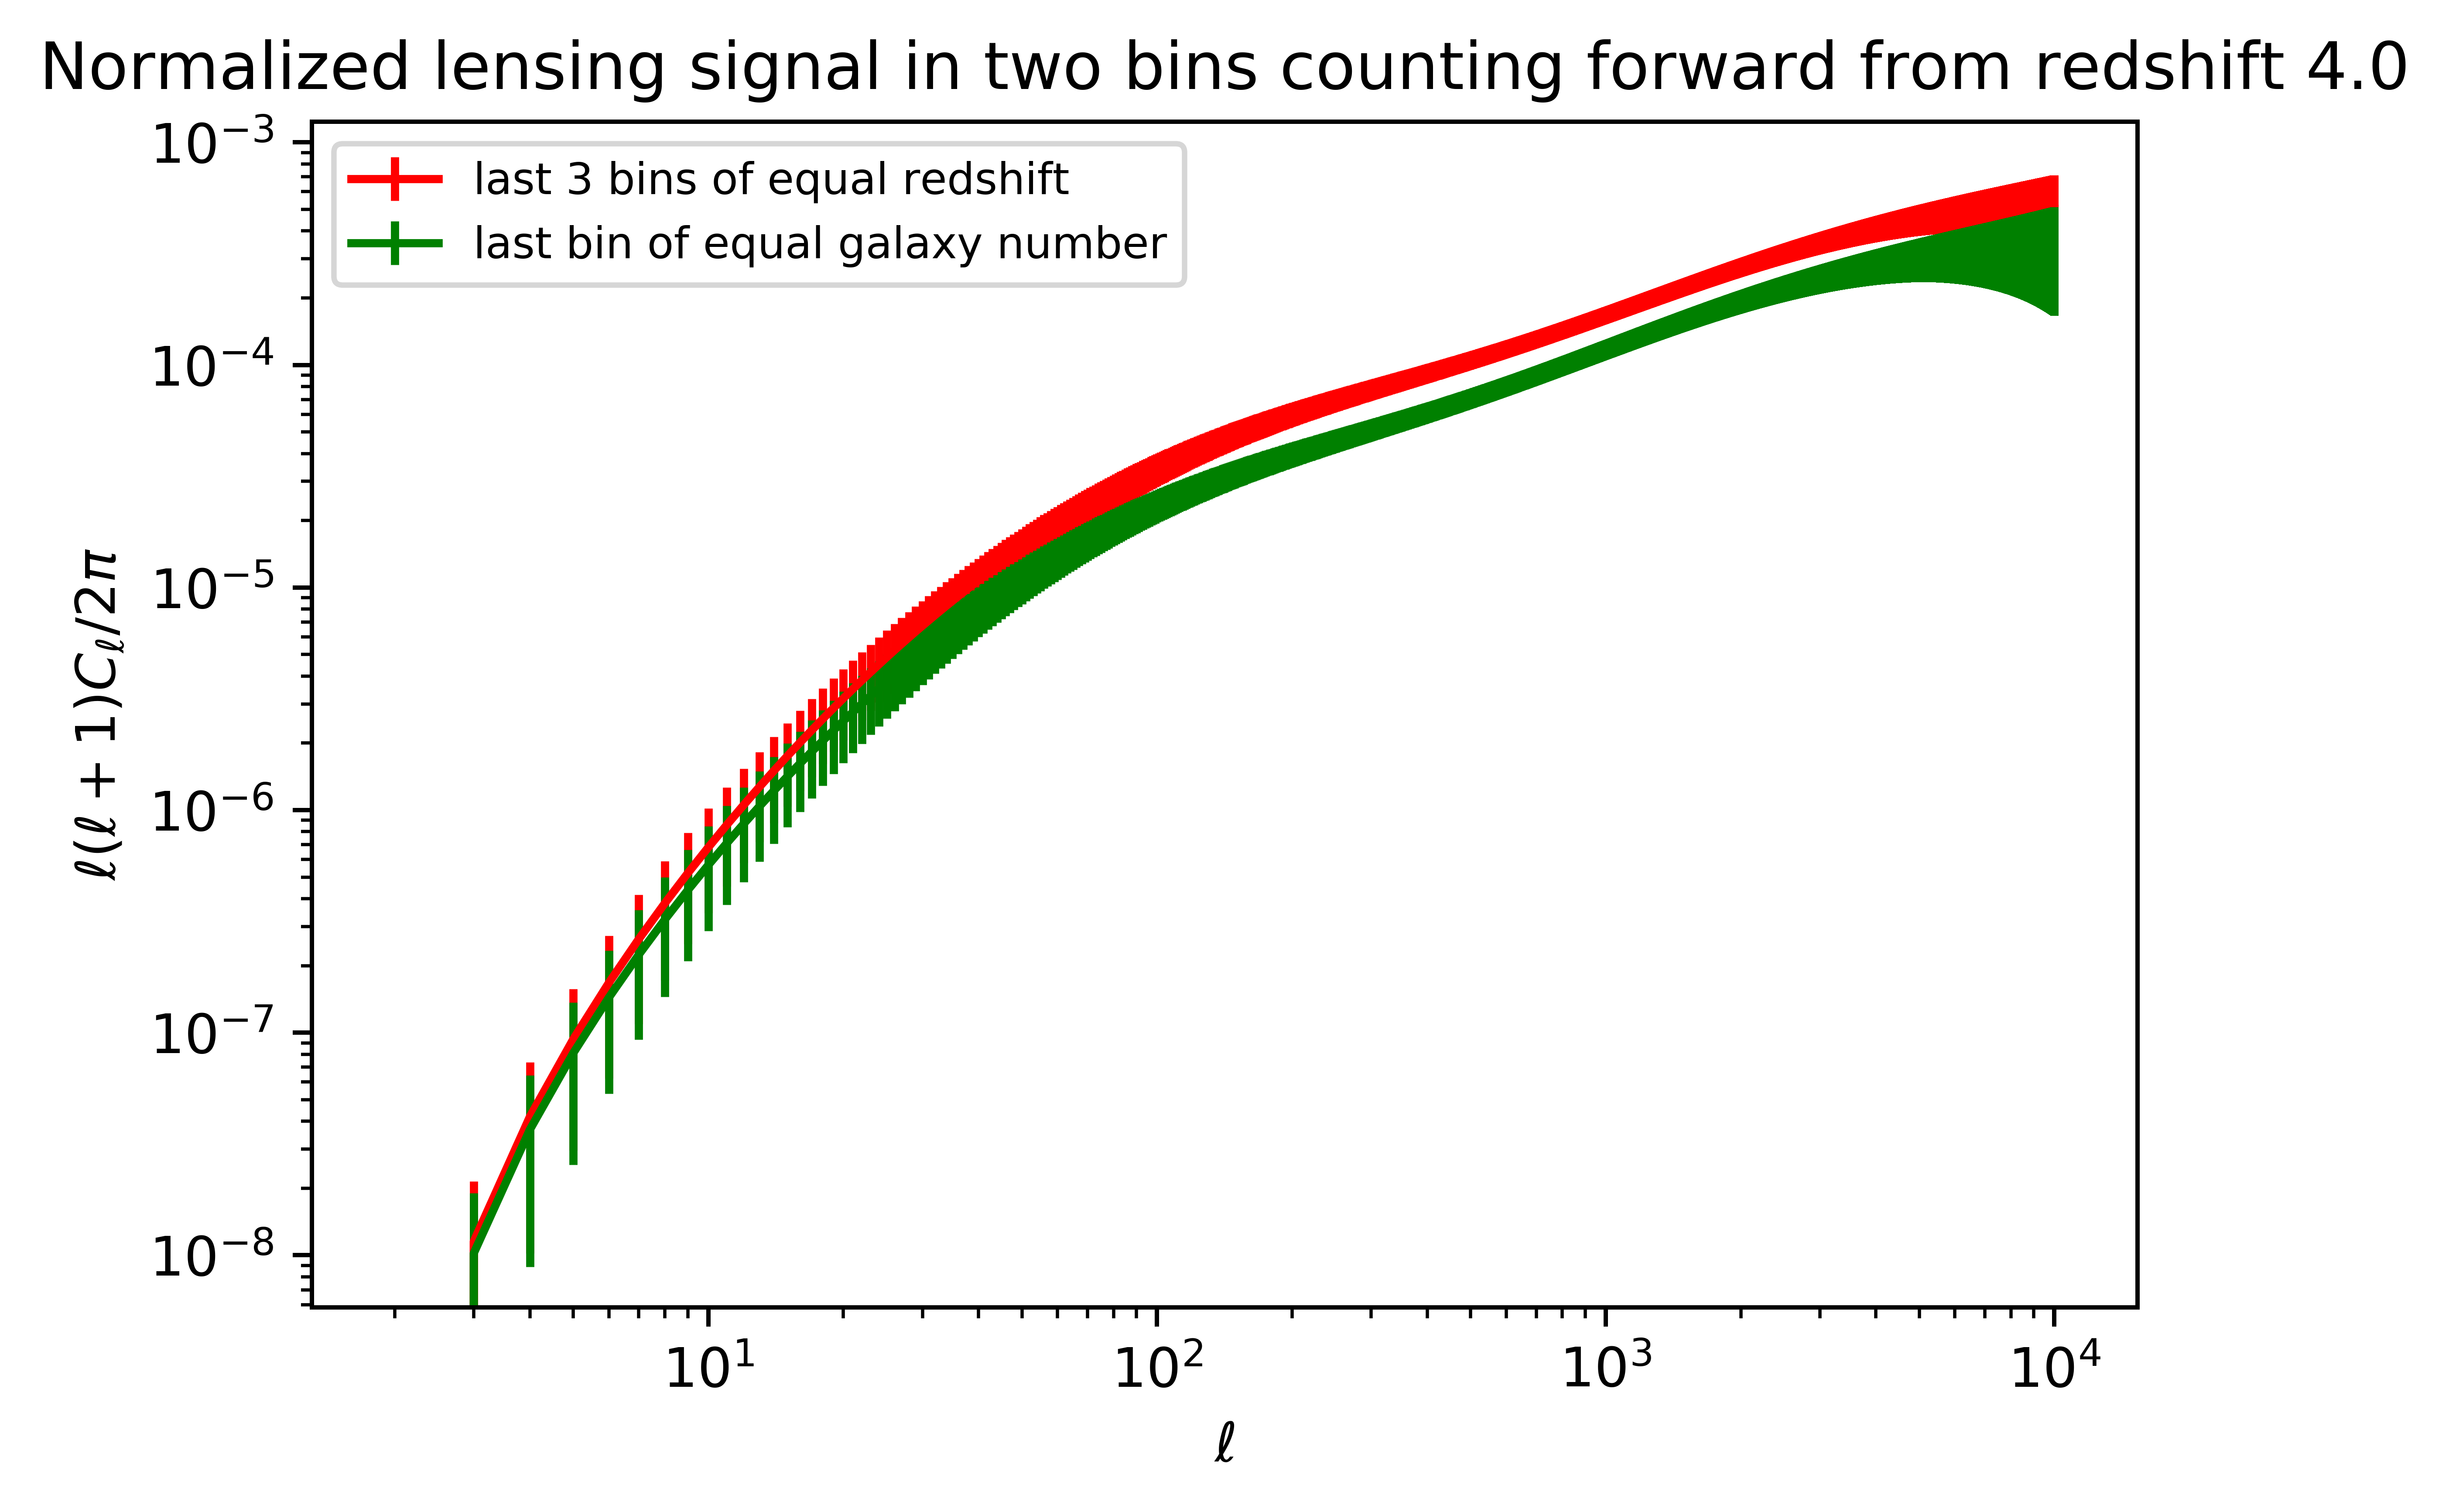

In [62]:
plt.figure()
plt.errorbar(ell, normalizing(cl_345short), yerr = normalizing(np.sqrt(cov_345short)), color='r', label = "last 3 bins of equal redshift")
plt.errorbar(ell, normalizing(cl_5long), yerr = normalizing(np.sqrt(cov_5long)), color='g', label = "last bin of equal galaxy number")
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in two bins counting forward from redshift 4.0")
plt.show() 

Question: why would adding more lower redshift galaxies reduce the lensing signal??? this doesn't make sense....

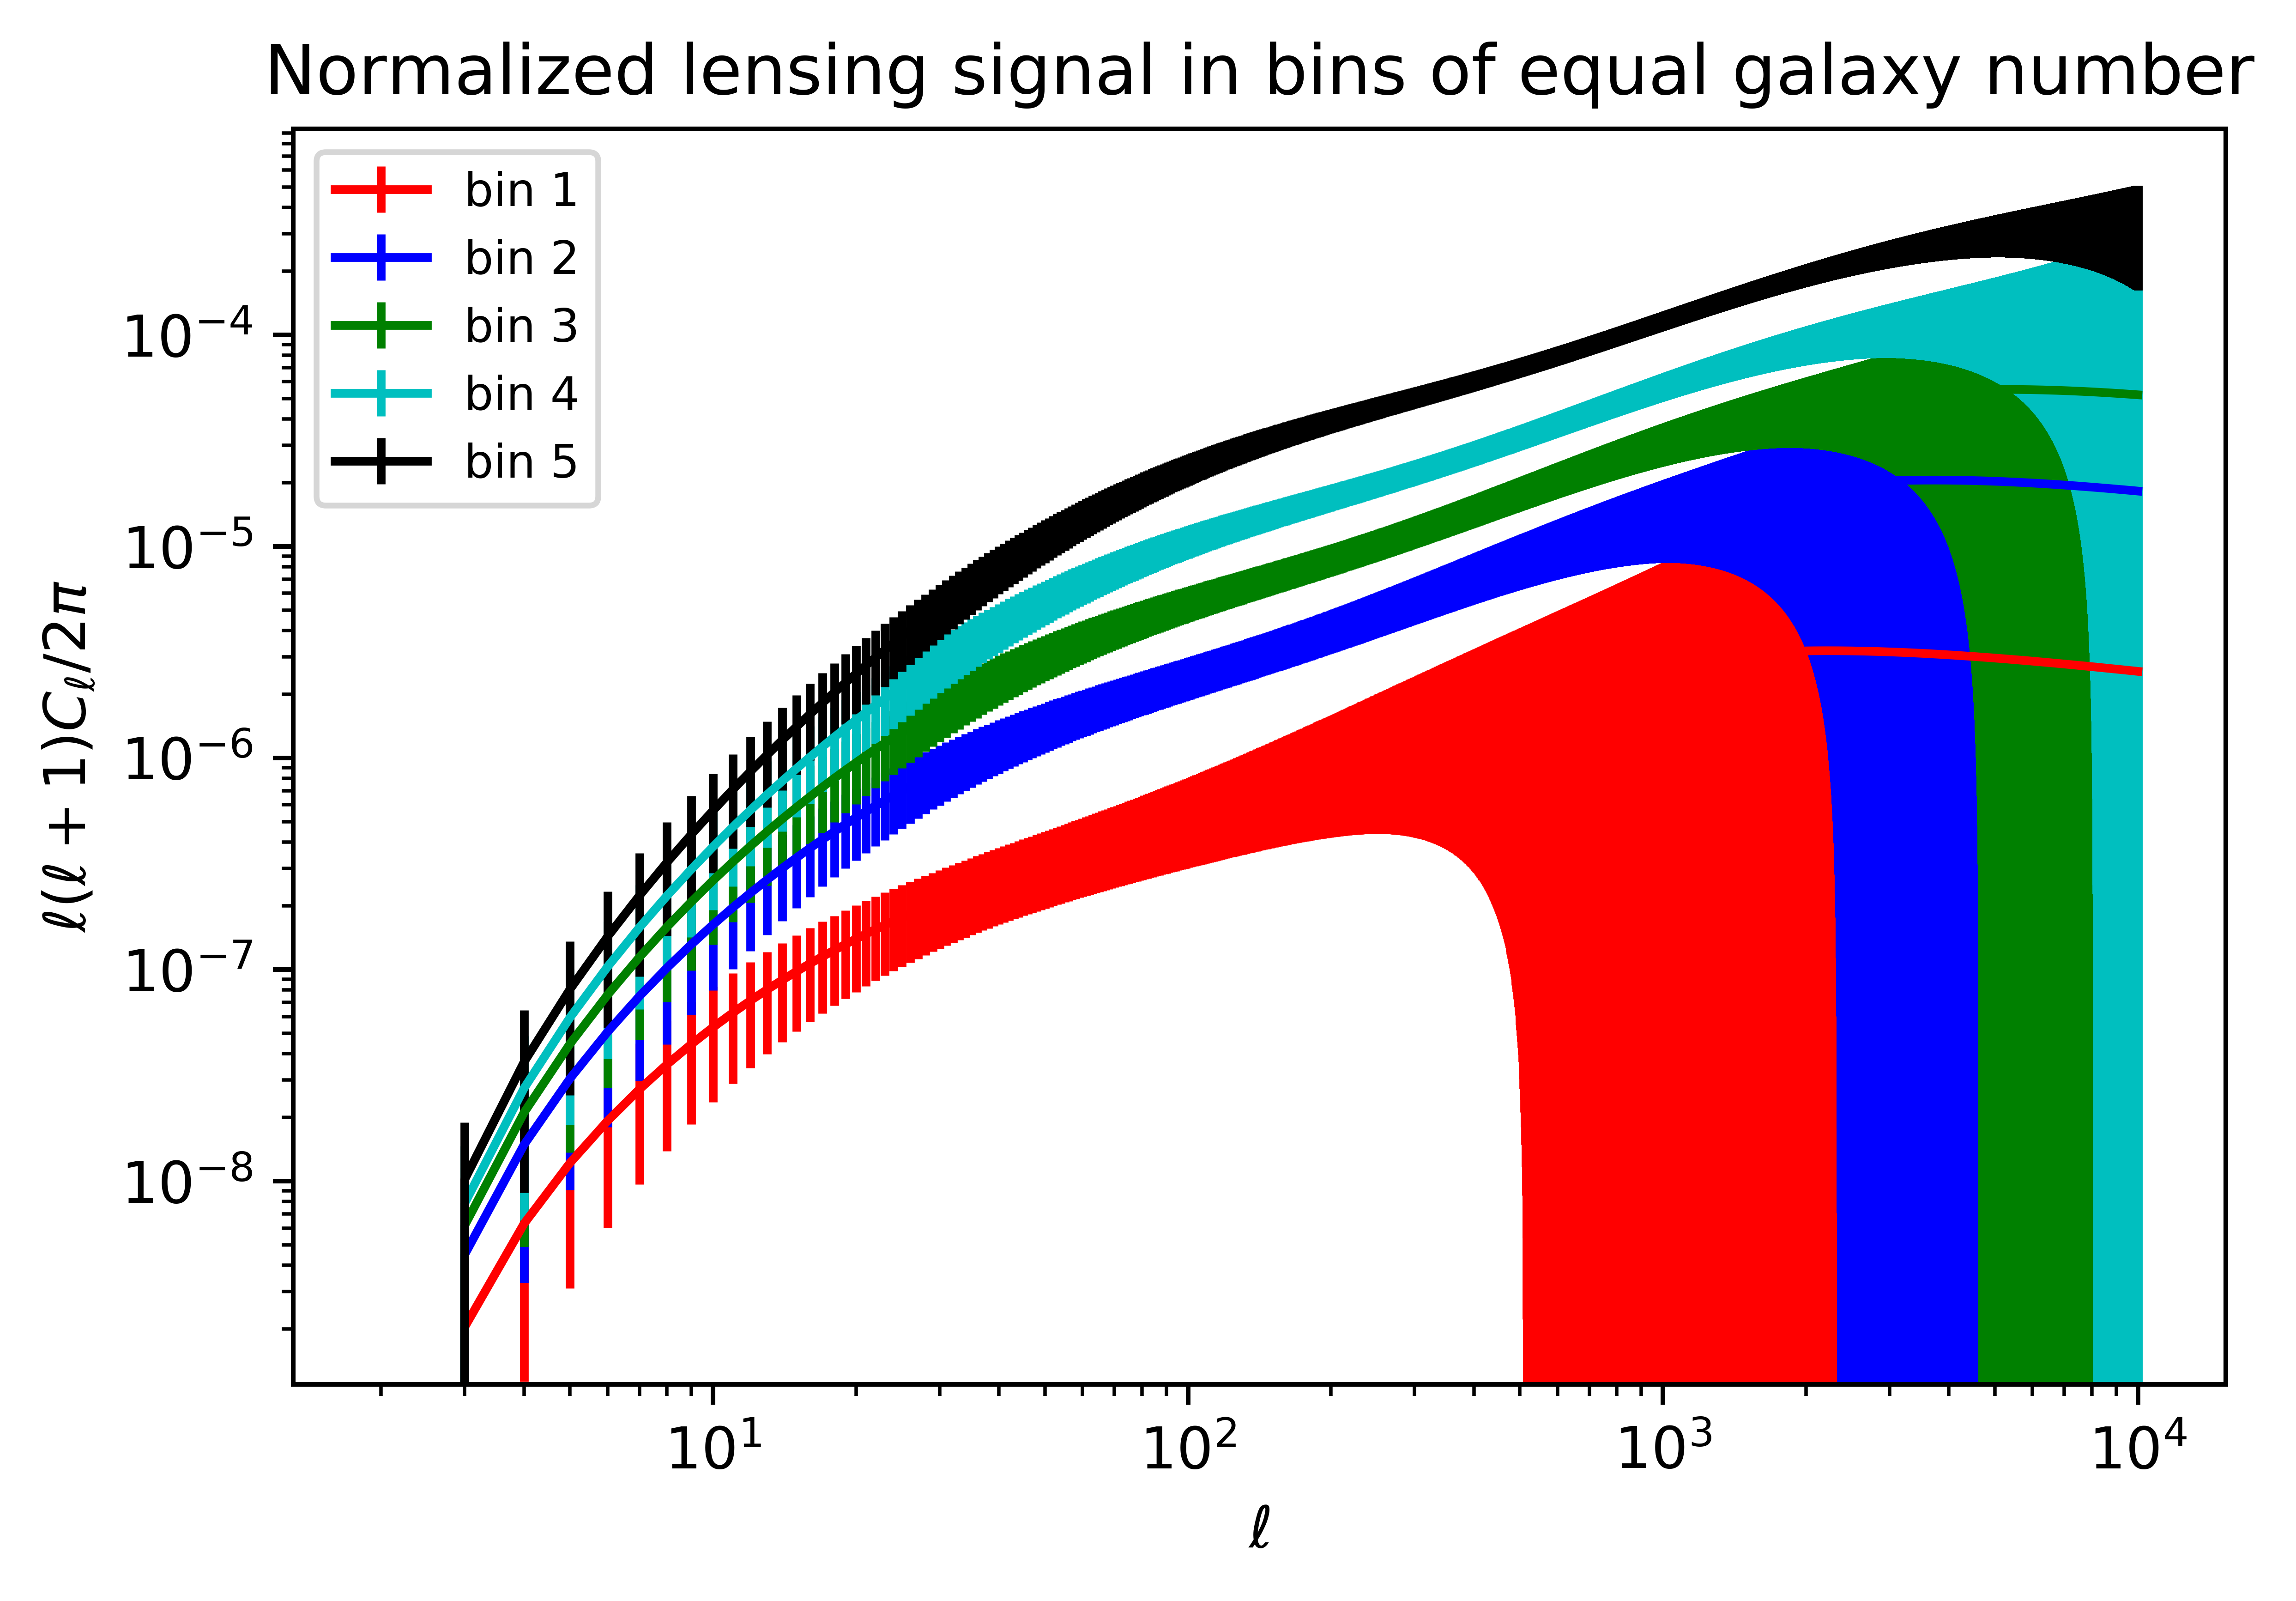

In [63]:
plt.figure()
plt.errorbar(ell, normalizing(cl["n_5"][0]), yerr = normalizing(np.sqrt(cov["n_5"][:, 0, 0])), color='r', label = "bin 1")
plt.errorbar(ell, normalizing(cl["n_5"][5]), yerr = normalizing(np.sqrt(cov["n_5"][:, 5, 5])), color='b', label = "bin 2")
plt.errorbar(ell, normalizing(cl["n_5"][9]), yerr = normalizing(np.sqrt(cov["n_5"][:, 9, 9])), color='g', label = "bin 3")
plt.errorbar(ell, normalizing(cl["n_5"][12]), yerr = normalizing(np.sqrt(cov["n_5"][:, 12, 12])), color='c', label = "bin 4")
plt.errorbar(ell, normalizing(cl["n_5"][14]), yerr = normalizing(np.sqrt(cov["n_5"][:, 14, 14])), color='k', label = "bin 5")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in bins of equal galaxy number")
plt.show() 

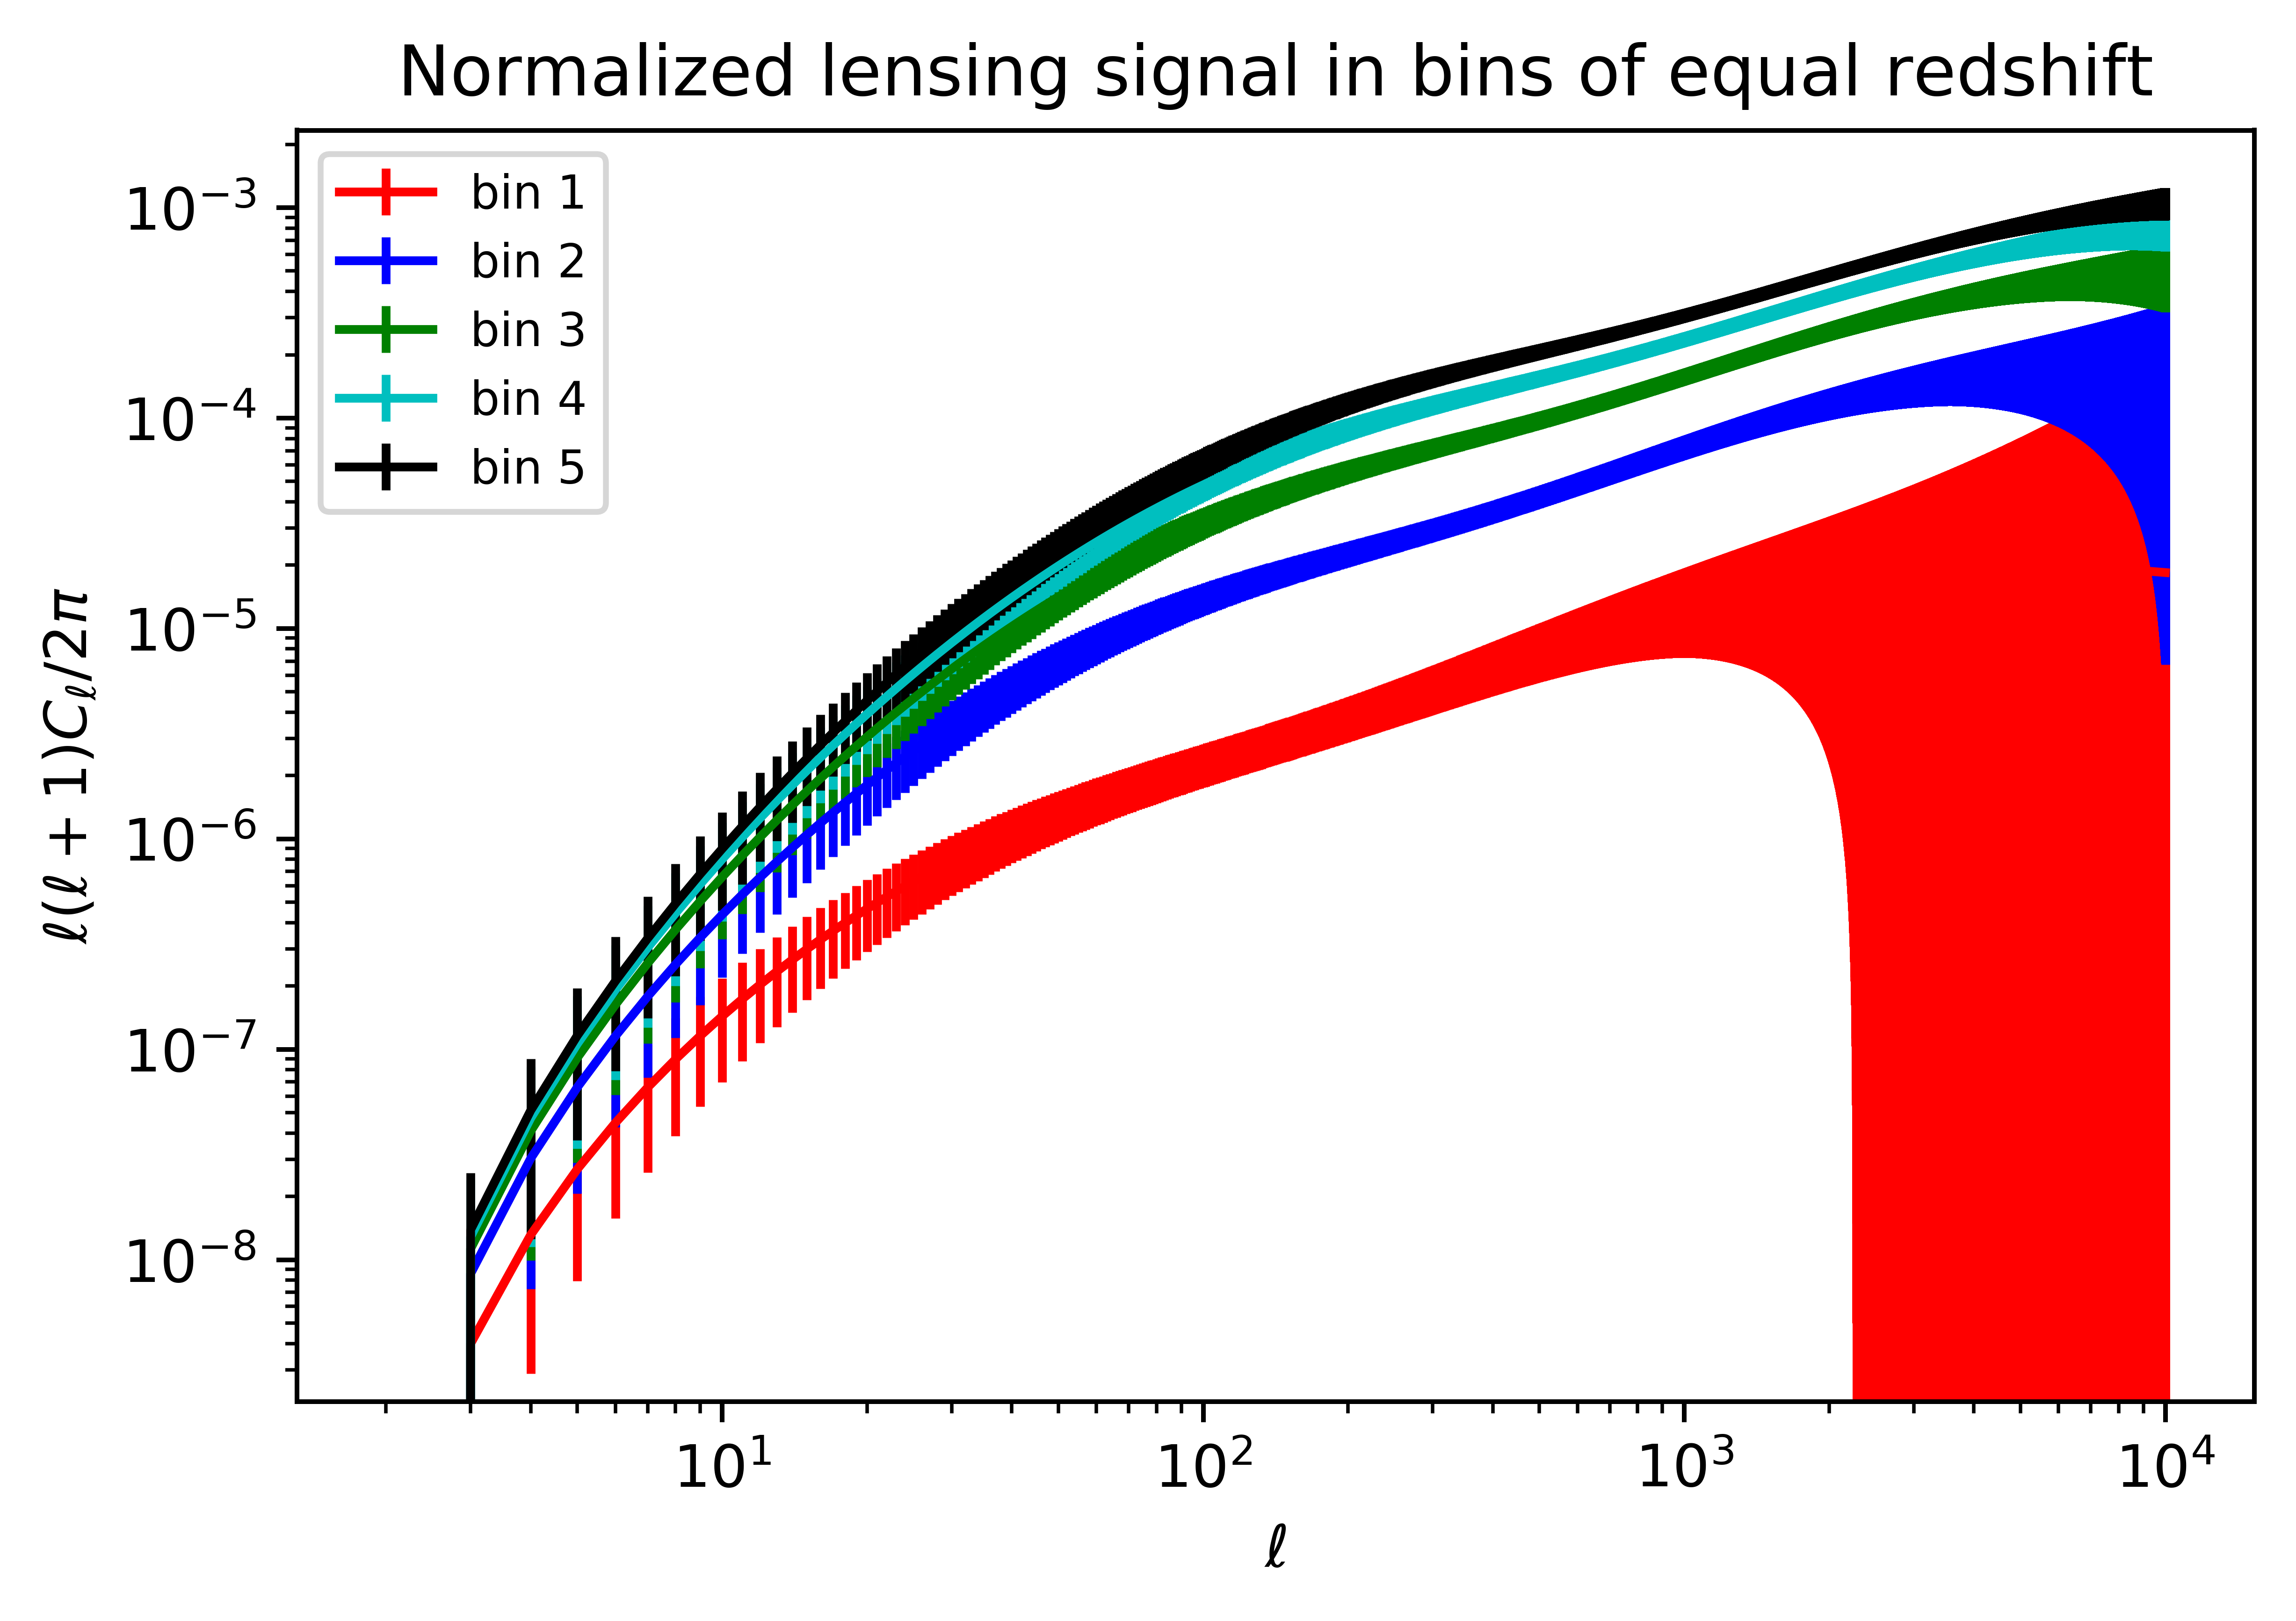

In [64]:
plt.figure()
plt.errorbar(ell, normalizing(cl["z_5"][0]), yerr = normalizing(np.sqrt(cov["z_5"][:, 0, 0])), color='r', label = "bin 1")
plt.errorbar(ell, normalizing(cl["z_5"][5]), yerr = normalizing(np.sqrt(cov["z_5"][:, 5, 5])), color='b', label = "bin 2")
plt.errorbar(ell, normalizing(cl["z_5"][9]), yerr = normalizing(np.sqrt(cov["z_5"][:, 9, 9])), color='g', label = "bin 3")
plt.errorbar(ell, normalizing(cl["z_5"][12]), yerr = normalizing(np.sqrt(cov["z_5"][:, 12, 12])), color='c', label = "bin 4")
plt.errorbar(ell, normalizing(cl["z_5"][14]), yerr = normalizing(np.sqrt(cov["z_5"][:, 14, 14])), color='k', label = "bin 5")

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1)C_{\ell}/2\pi$')
plt.legend(loc="upper left")
plt.title("Normalized lensing signal in bins of equal redshift")
plt.show() 

this make sense, in both dividing, lensing signal increase as redshift increases